## Experiment 4: cell type specificity of regression models

This experiment studies whether cluster-specific ridge regression is superior to regression shared across all training data. 

In [1]:
EXPERIMENT_NAME="pruning_v1"

In [54]:
import warnings
warnings.filterwarnings('ignore')
import importlib
import os
import sys
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
import sklearn
import joblib

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [55]:
# Deal with various file paths specific to this project
PROJECT_PATH = '/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/'
os.chdir(PROJECT_PATH + "benchmarking/")
try:
    os.makedirs("results/" + EXPERIMENT_NAME)
except:
    pass

sys.path.append(os.path.expanduser(PROJECT_PATH + 'networks/load_networks'))
sys.path.append(os.path.expanduser(PROJECT_PATH + 'perturbations/load_perturbations')) 
sys.path.append(os.path.expanduser(PROJECT_PATH + 'benchmarking/evaluator')) 
import evaluator
import load_networks
import load_perturbations
importlib.reload(evaluator) 
importlib.reload(load_networks) 
importlib.reload(load_perturbations)
os.environ["GRN_PATH"]           = PROJECT_PATH + "networks/networks"
os.environ["PERTURBATION_PATH"]  = PROJECT_PATH + "perturbations/perturbations"

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


### Networks setup

This experiment is about permissive or data-adaptive sparsity, so we start with the dense network instead of a base GRN.

In [4]:
networks = {
    'dense': evaluator.makeRandomNetwork(density = 1)
}
network_sizes = pd.DataFrame({bn:evaluator.countMatrixEdges(networks[bn]) for bn in networks}, index = ["numEdges"])
network_sizes = network_sizes.T.reset_index().rename({"index":"network"}, axis = 1)
network_sizes

,network,numEdges
0,dense,102313295.0


### Data setup

We use the Nakatake et al data. 

In [5]:
ko_lab_esc_data = sc.read_h5ad(os.environ["PERTURBATION_PATH"] + "/nakatake/" + "test.h5ad")

In [49]:
cellFateClassifier = sklearn.linear_model.LogisticRegressionCV(Cs=10,
                                                               solver="liblinear",
                                                               verbose=1)
cellFateClassifier.fit(X=ko_lab_esc_data.X, y=ko_lab_esc_data.obs["leiden"])
import joblib
joblib.dump(cellFateClassifier, os.environ["PERTURBATION_PATH"] + "/nakatake/" + "classifier.joblib")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear]iter  1 act 1.786e-02 pre 1.686e-02 delta 3.523e-02 f 5.608e-02 |g| 1.017e+00 CG   1
iter  2 act 1.024e-03 pre 9.996e-04 delta 3.580e-02 f 3.822e-02 |g| 1.197e-01 CG   2
iter  3 act 2.890e-06 pre 2.884e-06 delta 3.580e-02 f 3.719e-02 |g| 8.335e-03 CG   2
iter  4 act 2.500e-09 pre 2.500e-09 delta 3.580e-02 f 3.719e-02 |g| 8.510e-05 CG   2
[LibLinear]iter  1 act 1.430e-01 pre 1.344e-01 delta 3.645e-02 f 4.342e-01 |g| 7.877e+00 CG   1
cg reaches trust region boundary
iter  2 act 1.326e-02 pre 1.295e-02 delta 7.072e-02 f 2.912e-01 |g| 9.972e-01 CG   2
cg reaches trust region boundary
iter  3 act 1.250e-02 pre 1.222e-02 delta 1.224e-01 f 2.780e-01 |g| 2.485e-01 CG   1
iter  4 act 3.823e-03 pre 3.777e-03 delta 1.224e-01 f 2.655e-01 |g| 2.076e-01 CG   2
iter  5 act 1.551e-04 pre 1.551e-04 delta 1.224e-01 f 2.616e-01 |g| 4.523e-02 CG   2
iter  6 act 1.886e-06 pre 1.885e-06 delta 1.224e-01 f 2.615e-01 |g| 2.499e-03 CG   3
[LibLinear]iter  1 act 1.112e+00 pre 1.044e+00 delta 3.661e-02

cg reaches trust region boundary
iter 13 act 2.779e+03 pre 2.260e+03 delta 9.325e+00 f 5.060e+03 |g| 4.808e+03 CG   7
iter 14 act 1.132e+03 pre 9.246e+02 delta 9.372e+00 f 2.280e+03 |g| 1.129e+03 CG   9
iter 15 act 2.698e+02 pre 2.272e+02 delta 9.372e+00 f 1.149e+03 |g| 1.972e+02 CG   9
iter 16 act 3.910e+01 pre 3.494e+01 delta 9.372e+00 f 8.788e+02 |g| 1.199e+02 CG   8
iter 17 act 2.002e+00 pre 1.802e+00 delta 9.372e+00 f 8.397e+02 |g| 6.380e+01 CG   4
iter 18 act 3.061e+00 pre 3.024e+00 delta 9.372e+00 f 8.377e+02 |g| 3.034e+01 CG   8
[LibLinear]iter  1 act 2.397e+05 pre 2.251e+05 delta 3.664e-02 f 7.242e+05 |g| 1.314e+07 CG   1
cg reaches trust region boundary
iter  2 act 2.353e+04 pre 2.299e+04 delta 8.084e-02 f 4.846e+05 |g| 1.682e+06 CG   2
cg reaches trust region boundary
iter  3 act 3.320e+04 pre 3.284e+04 delta 2.919e-01 f 4.610e+05 |g| 4.768e+05 CG   1
cg reaches trust region boundary
iter  4 act 6.495e+04 pre 5.366e+04 delta 4.010e-01 f 4.278e+05 |g| 4.003e+05 CG   3
cg reac

[LibLinear]iter  1 act 5.165e+02 pre 4.852e+02 delta 3.669e-02 f 1.560e+03 |g| 2.828e+04 CG   1
cg reaches trust region boundary
iter  2 act 5.072e+01 pre 4.957e+01 delta 8.116e-02 f 1.044e+03 |g| 3.620e+03 CG   2
cg reaches trust region boundary
iter  3 act 7.201e+01 pre 7.130e+01 delta 2.968e-01 f 9.931e+02 |g| 1.028e+03 CG   1
cg reaches trust region boundary
iter  4 act 1.436e+02 pre 1.182e+02 delta 4.091e-01 f 9.211e+02 |g| 8.903e+02 CG   3
cg reaches trust region boundary
iter  5 act 1.025e+02 pre 8.252e+01 delta 6.909e-01 f 7.775e+02 |g| 2.210e+03 CG   2
cg reaches trust region boundary
iter  6 act 1.128e+02 pre 1.065e+02 delta 1.656e+00 f 6.750e+02 |g| 1.267e+03 CG   2
cg reaches trust region boundary
iter  7 act 1.558e+02 pre 1.394e+02 delta 2.728e+00 f 5.622e+02 |g| 5.654e+02 CG   2
iter  8 act 9.983e-01 pre 9.916e-01 delta 2.728e+00 f 4.065e+02 |g| 7.460e+02 CG   1
cg reaches trust region boundary
iter  9 act 1.239e+02 pre 1.024e+02 delta 3.597e+00 f 4.055e+02 |g| 7.317e+01 

iter 15 act 2.765e+04 pre 2.178e+04 delta 1.012e+01 f 4.663e+04 |g| 9.152e+04 CG   7
iter 16 act 1.044e+04 pre 8.222e+03 delta 1.012e+01 f 1.898e+04 |g| 3.862e+04 CG   8
iter 17 act 3.798e+02 pre 2.851e+02 delta 1.012e+01 f 8.541e+03 |g| 1.844e+04 CG   2
iter 18 act 4.169e+03 pre 3.323e+03 delta 1.012e+01 f 8.161e+03 |g| 5.317e+03 CG   8
iter 19 act 1.344e+03 pre 1.090e+03 delta 1.012e+01 f 3.992e+03 |g| 2.146e+03 CG   7
[LibLinear]iter  1 act 1.790e-02 pre 1.691e-02 delta 3.527e-02 f 5.614e-02 |g| 1.019e+00 CG   1
cg reaches trust region boundary
iter  2 act 1.050e-03 pre 1.025e-03 delta 3.630e-02 f 3.824e-02 |g| 1.201e-01 CG   2
iter  3 act 3.141e-06 pre 3.134e-06 delta 3.630e-02 f 3.719e-02 |g| 8.383e-03 CG   2
iter  4 act 4.239e-09 pre 4.239e-09 delta 3.630e-02 f 3.719e-02 |g| 1.055e-04 CG   2
[LibLinear]iter  1 act 1.433e-01 pre 1.347e-01 delta 3.649e-02 f 4.347e-01 |g| 7.888e+00 CG   1
cg reaches trust region boundary
iter  2 act 1.348e-02 pre 1.317e-02 delta 7.117e-02 f 2.914e-0

iter  9 act 8.353e+03 pre 7.193e+03 delta 3.973e+00 f 2.468e+04 |g| 4.751e+03 CG   3
cg reaches trust region boundary
iter 10 act 6.689e+03 pre 5.563e+03 delta 5.502e+00 f 1.633e+04 |g| 3.054e+04 CG   3
iter 11 act 3.519e+01 pre 3.512e+01 delta 5.502e+00 f 9.638e+03 |g| 2.404e+04 CG   1
cg reaches trust region boundary
iter 12 act 4.654e+03 pre 3.947e+03 delta 7.484e+00 f 9.602e+03 |g| 1.840e+03 CG   4
iter 13 act 2.757e+03 pre 2.231e+03 delta 9.364e+00 f 4.948e+03 |g| 6.664e+03 CG   7
iter 14 act 1.024e+03 pre 8.313e+02 delta 9.364e+00 f 2.191e+03 |g| 2.348e+03 CG   8
iter 15 act 5.293e+01 pre 4.337e+01 delta 9.364e+00 f 1.167e+03 |g| 1.348e+03 CG   3
iter 16 act 2.396e+02 pre 2.031e+02 delta 9.364e+00 f 1.114e+03 |g| 1.256e+02 CG   9
iter 17 act 3.350e+01 pre 3.061e+01 delta 9.364e+00 f 8.747e+02 |g| 3.517e+01 CG  16
[LibLinear]iter  1 act 2.403e+05 pre 2.257e+05 delta 3.668e-02 f 7.251e+05 |g| 1.316e+07 CG   1
cg reaches trust region boundary
iter  2 act 2.390e+04 pre 2.335e+04 delt

[LibLinear]iter  1 act 5.183e+02 pre 4.868e+02 delta 3.667e-02 f 1.562e+03 |g| 2.839e+04 CG   1
cg reaches trust region boundary
iter  2 act 5.104e+01 pre 4.986e+01 delta 8.084e-02 f 1.044e+03 |g| 3.641e+03 CG   2
cg reaches trust region boundary
iter  3 act 7.200e+01 pre 7.117e+01 delta 2.937e-01 f 9.929e+02 |g| 1.033e+03 CG   1
cg reaches trust region boundary
iter  4 act 1.417e+02 pre 1.169e+02 delta 4.033e-01 f 9.210e+02 |g| 8.404e+02 CG   3
cg reaches trust region boundary
iter  5 act 1.010e+02 pre 8.194e+01 delta 6.847e-01 f 7.792e+02 |g| 2.194e+03 CG   2
cg reaches trust region boundary
iter  6 act 1.131e+02 pre 1.074e+02 delta 1.683e+00 f 6.782e+02 |g| 1.241e+03 CG   2
cg reaches trust region boundary
iter  7 act 1.605e+02 pre 1.436e+02 delta 2.745e+00 f 5.651e+02 |g| 5.389e+02 CG   2
iter  8 act 9.757e-01 pre 9.689e-01 delta 2.745e+00 f 4.046e+02 |g| 7.388e+02 CG   1
cg reaches trust region boundary
iter  9 act 1.277e+02 pre 1.046e+02 delta 3.744e+00 f 4.036e+02 |g| 7.346e+01 

iter 16 act 2.358e+04 pre 1.872e+04 delta 9.954e+00 f 3.802e+04 |g| 2.095e+04 CG   7
iter 17 act 8.316e+03 pre 6.603e+03 delta 9.954e+00 f 1.444e+04 |g| 9.622e+03 CG   6
iter 18 act 2.896e+03 pre 2.320e+03 delta 9.954e+00 f 6.126e+03 |g| 4.081e+03 CG   7
[LibLinear]iter  1 act 1.776e-02 pre 1.678e-02 delta 3.512e-02 f 5.614e-02 |g| 1.015e+00 CG   1
iter  2 act 1.022e-03 pre 9.980e-04 delta 3.590e-02 f 3.839e-02 |g| 1.189e-01 CG   2
iter  3 act 2.817e-06 pre 2.811e-06 delta 3.590e-02 f 3.736e-02 |g| 8.212e-03 CG   2
iter  4 act 2.372e-09 pre 2.372e-09 delta 3.590e-02 f 3.736e-02 |g| 8.269e-05 CG   2
[LibLinear]iter  1 act 1.422e-01 pre 1.337e-01 delta 3.634e-02 f 4.347e-01 |g| 7.857e+00 CG   1
cg reaches trust region boundary
iter  2 act 1.320e-02 pre 1.291e-02 delta 7.097e-02 f 2.925e-01 |g| 9.902e-01 CG   2
cg reaches trust region boundary
iter  3 act 1.271e-02 pre 1.248e-02 delta 1.257e-01 f 2.793e-01 |g| 2.496e-01 CG   1
iter  4 act 3.955e-03 pre 3.897e-03 delta 1.257e-01 f 2.666e-0

iter 22 act 3.350e-01 pre 3.383e-01 delta 5.520e+00 f 4.000e+02 |g| 6.047e+00 CG  11
[LibLinear]iter  1 act 3.079e+04 pre 2.893e+04 delta 3.653e-02 f 9.366e+04 |g| 1.693e+06 CG   1
cg reaches trust region boundary
iter  2 act 3.026e+03 pre 2.958e+03 delta 8.119e-02 f 6.287e+04 |g| 2.157e+05 CG   2
cg reaches trust region boundary
iter  3 act 4.296e+03 pre 4.264e+03 delta 2.824e-01 f 5.984e+04 |g| 6.180e+04 CG   1
cg reaches trust region boundary
iter  4 act 8.278e+03 pre 6.718e+03 delta 3.910e-01 f 5.554e+04 |g| 6.570e+04 CG   3
cg reaches trust region boundary
iter  5 act 6.077e+03 pre 4.987e+03 delta 6.859e-01 f 4.727e+04 |g| 1.286e+05 CG   2
cg reaches trust region boundary
iter  6 act 7.009e+03 pre 6.628e+03 delta 1.688e+00 f 4.119e+04 |g| 7.170e+04 CG   2
cg reaches trust region boundary
iter  7 act 1.006e+04 pre 9.001e+03 delta 2.795e+00 f 3.418e+04 |g| 3.443e+04 CG   2
iter  8 act 6.698e+01 pre 6.650e+01 delta 2.795e+00 f 2.412e+04 |g| 4.755e+04 CG   1
cg reaches trust region bo

iter  6 act 3.518e-03 pre 3.518e-03 delta 2.723e-01 f 1.527e+00 |g| 3.146e-01 CG   3
iter  7 act 1.866e-05 pre 1.866e-05 delta 2.723e-01 f 1.524e+00 |g| 1.693e-02 CG   3
iter  8 act 2.655e-07 pre 2.655e-07 delta 2.723e-01 f 1.524e+00 |g| 1.015e-03 CG   4
[LibLinear]iter  1 act 1.152e+01 pre 1.064e+01 delta 4.280e-02 f 2.603e+01 |g| 5.419e+02 CG   1
cg reaches trust region boundary
iter  2 act 9.323e-01 pre 8.816e-01 delta 6.602e-02 f 1.451e+01 |g| 8.427e+01 CG   2
cg reaches trust region boundary
iter  3 act 6.087e-01 pre 5.949e-01 delta 2.163e-01 f 1.358e+01 |g| 1.443e+01 CG   2
cg reaches trust region boundary
iter  4 act 1.130e+00 pre 1.025e+00 delta 3.126e-01 f 1.297e+01 |g| 9.273e+00 CG   2
cg reaches trust region boundary
iter  5 act 1.080e+00 pre 1.028e+00 delta 7.797e-01 f 1.184e+01 |g| 2.001e+01 CG   2
cg reaches trust region boundary
iter  6 act 1.328e+00 pre 1.309e+00 delta 9.403e-01 f 1.076e+01 |g| 7.052e+00 CG   2
iter  7 act 3.916e-01 pre 3.735e-01 delta 9.403e-01 f 9.430

iter 23 act 4.459e+01 pre 3.554e+01 delta 3.621e+00 f 1.217e+03 |g| 3.110e+03 CG   2
cg reaches trust region boundary
iter 24 act 3.180e+02 pre 2.527e+02 delta 4.891e+00 f 1.172e+03 |g| 8.150e+02 CG   6
iter 25 act 1.650e+00 pre 1.649e+00 delta 4.891e+00 f 8.540e+02 |g| 1.598e+03 CG   1
iter 26 act 1.662e+02 pre 1.409e+02 delta 5.206e+00 f 8.523e+02 |g| 1.438e+02 CG  13
iter 27 act 2.269e+01 pre 2.019e+01 delta 5.206e+00 f 6.861e+02 |g| 9.432e+01 CG   9
iter 28 act 3.966e+00 pre 3.942e+00 delta 5.206e+00 f 6.634e+02 |g| 2.676e+01 CG  14
[LibLinear]iter  1 act 3.205e+05 pre 2.961e+05 delta 4.281e-02 f 7.242e+05 |g| 1.508e+07 CG   1
cg reaches trust region boundary
iter  2 act 2.597e+04 pre 2.456e+04 delta 6.615e-02 f 4.037e+05 |g| 2.345e+06 CG   2
cg reaches trust region boundary
iter  3 act 1.710e+04 pre 1.671e+04 delta 2.211e-01 f 3.777e+05 |g| 4.024e+05 CG   2
cg reaches trust region boundary
iter  4 act 3.312e+04 pre 3.003e+04 delta 3.298e-01 f 3.606e+05 |g| 2.622e+05 CG   2
cg reac

iter  9 act 8.737e-03 pre 8.717e-03 delta 9.293e-01 f 9.163e+00 |g| 1.420e+00 CG   2
iter 10 act 2.764e-03 pre 2.769e-03 delta 9.293e-01 f 9.154e+00 |g| 1.542e-01 CG   4
iter 11 act 3.996e-05 pre 3.994e-05 delta 9.293e-01 f 9.152e+00 |g| 2.520e-02 CG   4
[LibLinear]iter  1 act 8.911e+01 pre 8.233e+01 delta 4.284e-02 f 2.015e+02 |g| 4.189e+03 CG   1
cg reaches trust region boundary
iter  2 act 7.185e+00 pre 6.796e+00 delta 6.609e-02 f 1.124e+02 |g| 6.510e+02 CG   2
cg reaches trust region boundary
iter  3 act 4.705e+00 pre 4.599e+00 delta 2.205e-01 f 1.052e+02 |g| 1.111e+02 CG   2
cg reaches trust region boundary
iter  4 act 9.017e+00 pre 8.165e+00 delta 3.243e-01 f 1.005e+02 |g| 7.202e+01 CG   2
cg reaches trust region boundary
iter  5 act 9.204e+00 pre 8.716e+00 delta 9.383e-01 f 9.151e+01 |g| 1.605e+02 CG   2
cg reaches trust region boundary
iter  6 act 1.640e+01 pre 1.600e+01 delta 1.551e+00 f 8.231e+01 |g| 5.979e+01 CG   2
cg reaches trust region boundary
iter  7 act 1.411e+01 pre 

iter  9 act 5.136e+04 pre 4.325e+04 delta 3.833e+00 f 1.660e+05 |g| 3.072e+04 CG   2
iter 10 act 7.554e+03 pre 7.099e+03 delta 3.833e+00 f 1.147e+05 |g| 2.569e+05 CG   2
cg reaches trust region boundary
iter 11 act 3.327e+04 pre 3.609e+04 delta 3.967e+00 f 1.071e+05 |g| 6.880e+04 CG   4
iter 12 act 9.310e+03 pre 8.893e+03 delta 3.967e+00 f 7.384e+04 |g| 3.258e+05 CG   2
cg reaches trust region boundary
iter 13 act 2.590e+04 pre 2.324e+04 delta 5.504e+00 f 6.453e+04 |g| 5.951e+04 CG   5
iter 14 act 1.651e+03 pre 1.376e+03 delta 5.504e+00 f 3.863e+04 |g| 1.258e+05 CG   2
cg reaches trust region boundary
iter 15 act 1.786e+04 pre 1.558e+04 delta 6.745e+00 f 3.698e+04 |g| 2.167e+04 CG   5
iter 16 act 1.375e+03 pre 1.200e+03 delta 6.745e+00 f 1.911e+04 |g| 8.849e+04 CG   2
cg reaches trust region boundary
iter 17 act 1.074e+04 pre 8.629e+03 delta 9.002e+00 f 1.774e+04 |g| 1.711e+04 CG   8
iter 18 act 6.952e+02 pre 5.634e+02 delta 9.002e+00 f 7.000e+03 |g| 1.517e+04 CG   3
iter 19 act 3.573e

cg reaches trust region boundary
iter  9 act 1.148e+02 pre 1.049e+02 delta 3.969e+00 f 3.956e+02 |g| 7.934e+01 CG   3
iter 10 act 4.888e-01 pre 4.845e-01 delta 3.969e+00 f 2.808e+02 |g| 4.437e+02 CG   1
cg reaches trust region boundary
iter 11 act 8.468e+01 pre 7.591e+01 delta 4.871e+00 f 2.803e+02 |g| 4.264e+01 CG   4
iter 12 act 4.235e-01 pre 4.206e-01 delta 4.871e+00 f 1.956e+02 |g| 3.486e+02 CG   1
iter 13 act 3.249e+01 pre 3.125e+01 delta 4.871e+00 f 1.952e+02 |g| 2.996e+01 CG  14
iter 14 act 6.154e-02 pre 6.140e-02 delta 4.871e+00 f 1.627e+02 |g| 1.131e+02 CG   1
iter 15 act 1.120e+00 pre 1.044e+00 delta 4.871e+00 f 1.627e+02 |g| 8.471e+00 CG   8
iter 16 act 3.622e-02 pre 3.471e-02 delta 4.871e+00 f 1.615e+02 |g| 9.168e+00 CG   3
iter 17 act 3.837e-02 pre 3.815e-02 delta 4.871e+00 f 1.615e+02 |g| 1.039e+00 CG  12
[LibLinear]iter  1 act 5.363e+03 pre 4.955e+03 delta 4.287e-02 f 1.210e+04 |g| 2.520e+05 CG   1
cg reaches trust region boundary
iter  2 act 4.412e+02 pre 4.171e+02 delt

[LibLinear]iter  1 act 2.391e-02 pre 2.223e-02 delta 4.111e-02 f 5.614e-02 |g| 1.170e+00 CG   1
iter  2 act 1.056e-03 pre 1.004e-03 delta 4.111e-02 f 3.224e-02 |g| 1.671e-01 CG   2
iter  3 act 8.768e-06 pre 8.691e-06 delta 4.111e-02 f 3.118e-02 |g| 1.646e-02 CG   1
iter  4 act 5.772e-07 pre 5.772e-07 delta 4.111e-02 f 3.117e-02 |g| 1.097e-03 CG   2
iter  5 act 8.321e-10 pre 8.321e-10 delta 4.111e-02 f 3.117e-02 |g| 4.294e-05 CG   2
[LibLinear]iter  1 act 1.916e-01 pre 1.772e-01 delta 4.259e-02 f 4.347e-01 |g| 9.058e+00 CG   1
cg reaches trust region boundary
iter  2 act 1.442e-02 pre 1.362e-02 delta 5.926e-02 f 2.431e-01 |g| 1.395e+00 CG   2
cg reaches trust region boundary
iter  3 act 5.074e-03 pre 4.936e-03 delta 7.813e-02 f 2.287e-01 |g| 2.121e-01 CG   2
iter  4 act 5.952e-04 pre 5.930e-04 delta 7.813e-02 f 2.236e-01 |g| 4.179e-02 CG   3
iter  5 act 1.373e-07 pre 1.372e-07 delta 7.813e-02 f 2.230e-01 |g| 2.971e-03 CG   2
[LibLinear]iter  1 act 1.490e+00 pre 1.377e+00 delta 4.279e-02

cg reaches trust region boundary
iter 12 act 4.588e+03 pre 3.734e+03 delta 8.319e+00 f 8.427e+03 |g| 1.878e+03 CG   6
iter 13 act 1.830e+01 pre 1.819e+01 delta 8.319e+00 f 3.838e+03 |g| 1.216e+04 CG   1
iter 14 act 2.361e+03 pre 1.956e+03 delta 1.037e+01 f 3.820e+03 |g| 1.010e+03 CG  15
iter 15 act 4.893e+02 pre 3.973e+02 delta 1.037e+01 f 1.459e+03 |g| 2.368e+03 CG   7
iter 16 act 1.669e+01 pre 1.410e+01 delta 1.037e+01 f 9.696e+02 |g| 1.170e+03 CG   2
iter 17 act 1.542e+02 pre 1.310e+02 delta 1.037e+01 f 9.529e+02 |g| 3.611e+02 CG   8
iter 18 act 2.008e+01 pre 1.815e+01 delta 1.037e+01 f 7.987e+02 |g| 1.549e+02 CG   7
iter 19 act 3.320e+00 pre 3.178e+00 delta 1.037e+01 f 7.787e+02 |g| 3.813e+01 CG   9
iter 20 act 1.615e-01 pre 1.601e-01 delta 1.037e+01 f 7.753e+02 |g| 2.672e+01 CG   4
[LibLinear]iter  1 act 3.213e+05 pre 2.968e+05 delta 4.282e-02 f 7.251e+05 |g| 1.511e+07 CG   1
cg reaches trust region boundary
iter  2 act 2.608e+04 pre 2.465e+04 delta 6.609e-02 f 4.038e+05 |g| 2.353

iter  7 act 1.490e+01 pre 1.326e+01 delta 2.297e+00 f 6.602e+01 |g| 1.170e+02 CG   3
iter  8 act 1.281e-01 pre 1.262e-01 delta 2.297e+00 f 5.112e+01 |g| 9.182e+01 CG   1
cg reaches trust region boundary
iter  9 act 7.645e+00 pre 7.238e+00 delta 2.475e+00 f 5.099e+01 |g| 6.715e+00 CG   5
iter 10 act 2.084e-02 pre 2.072e-02 delta 2.475e+00 f 4.335e+01 |g| 3.301e+01 CG   1
iter 11 act 3.980e-01 pre 3.948e-01 delta 2.475e+00 f 4.333e+01 |g| 1.559e+00 CG   8
iter 12 act 1.263e-04 pre 1.262e-04 delta 2.475e+00 f 4.293e+01 |g| 2.511e+00 CG   1
iter 13 act 6.379e-03 pre 5.733e-03 delta 2.475e+00 f 4.293e+01 |g| 2.480e-01 CG   7
iter 14 act 3.178e-04 pre 3.091e-04 delta 2.475e+00 f 4.292e+01 |g| 9.423e-02 CG   5
[LibLinear]iter  1 act 6.868e+02 pre 6.348e+02 delta 4.268e-02 f 1.562e+03 |g| 3.240e+04 CG   1
cg reaches trust region boundary
iter  2 act 5.499e+01 pre 5.205e+01 delta 6.592e-02 f 8.754e+02 |g| 5.015e+03 CG   2
cg reaches trust region boundary
iter  3 act 3.615e+01 pre 3.534e+01 delt

iter 21 act 3.701e+02 pre 3.105e+02 delta 1.013e+01 f 1.701e+03 |g| 7.137e+02 CG   8
iter 22 act 3.937e+01 pre 3.376e+01 delta 1.013e+01 f 1.331e+03 |g| 5.643e+02 CG   4
iter 23 act 3.400e+01 pre 3.059e+01 delta 1.013e+01 f 1.292e+03 |g| 2.822e+02 CG   7
[LibLinear]iter  1 act 2.468e+06 pre 2.281e+06 delta 4.268e-02 f 5.614e+06 |g| 1.165e+08 CG   1
cg reaches trust region boundary
iter  2 act 1.976e+05 pre 1.871e+05 delta 6.592e-02 f 3.146e+06 |g| 1.802e+07 CG   2
cg reaches trust region boundary
iter  3 act 1.299e+05 pre 1.270e+05 delta 2.197e-01 f 2.949e+06 |g| 3.064e+06 CG   2
cg reaches trust region boundary
iter  4 act 2.498e+05 pre 2.264e+05 delta 3.255e-01 f 2.819e+06 |g| 2.004e+06 CG   2
cg reaches trust region boundary
iter  5 act 2.637e+05 pre 2.514e+05 delta 1.009e+00 f 2.569e+06 |g| 4.438e+06 CG   2
cg reaches trust region boundary
iter  6 act 5.117e+05 pre 4.941e+05 delta 1.710e+00 f 2.305e+06 |g| 1.609e+06 CG   2
cg reaches trust region boundary
iter  7 act 5.253e+05 pre 

cg reaches trust region boundary
iter  3 act 3.798e+02 pre 3.559e+02 delta 1.099e-01 f 2.479e+03 |g| 1.976e+04 CG   2
cg reaches trust region boundary
iter  4 act 4.251e+02 pre 4.201e+02 delta 4.395e-01 f 2.099e+03 |g| 5.442e+03 CG   2
cg reaches trust region boundary
iter  5 act 7.882e+02 pre 9.478e+02 delta 4.456e-01 f 1.674e+03 |g| 4.168e+03 CG   2
cg reaches trust region boundary
iter  6 act 4.181e+02 pre 3.426e+02 delta 6.421e-01 f 8.857e+02 |g| 8.003e+03 CG   3
cg reaches trust region boundary
iter  7 act 2.660e+02 pre 2.133e+02 delta 8.637e-01 f 4.676e+02 |g| 4.302e+03 CG   2
iter  8 act 1.311e+02 pre 1.078e+02 delta 9.870e-01 f 2.016e+02 |g| 2.305e+03 CG   2
iter  9 act 8.941e+00 pre 8.170e+00 delta 9.870e-01 f 7.052e+01 |g| 1.204e+03 CG   1
iter 10 act 3.717e+01 pre 3.029e+01 delta 9.870e-01 f 6.158e+01 |g| 1.811e+02 CG   3
iter 11 act 1.076e+01 pre 8.691e+00 delta 9.870e-01 f 2.441e+01 |g| 1.266e+02 CG   3
iter 12 act 2.954e+00 pre 2.455e+00 delta 9.870e-01 f 1.365e+01 |g| 5.

iter  9 act 1.628e-03 pre 1.635e-03 delta 5.124e-01 f 1.087e+00 |g| 3.652e-01 CG   3
iter 10 act 8.298e-05 pre 8.283e-05 delta 5.124e-01 f 1.086e+00 |g| 2.621e-02 CG   4
[LibLinear]iter  1 act 1.433e+02 pre 1.280e+02 delta 5.566e-02 f 2.015e+02 |g| 5.223e+03 CG   1
iter  2 act 1.585e+01 pre 1.326e+01 delta 5.566e-02 f 5.825e+01 |g| 1.138e+03 CG   1
cg reaches trust region boundary
iter  3 act 6.657e+00 pre 6.270e+00 delta 1.149e-01 f 4.240e+01 |g| 3.258e+02 CG   2
cg reaches trust region boundary
iter  4 act 8.120e+00 pre 7.994e+00 delta 4.408e-01 f 3.574e+01 |g| 9.377e+01 CG   2
cg reaches trust region boundary
iter  5 act 1.442e+01 pre 1.728e+01 delta 4.420e-01 f 2.762e+01 |g| 8.478e+01 CG   2
cg reaches trust region boundary
iter  6 act 6.595e+00 pre 5.369e+00 delta 6.035e-01 f 1.320e+01 |g| 1.262e+02 CG   3
iter  7 act 3.056e+00 pre 2.501e+00 delta 6.138e-01 f 6.602e+00 |g| 7.096e+01 CG   2
iter  8 act 1.903e-01 pre 1.768e-01 delta 6.138e-01 f 3.546e+00 |g| 3.231e+01 CG   1
iter  9

[LibLinear]iter  1 act 3.825e-02 pre 3.447e-02 delta 5.318e-02 f 5.614e-02 |g| 1.456e+00 CG   1
iter  2 act 3.214e-03 pre 2.792e-03 delta 5.318e-02 f 1.790e-02 |g| 2.919e-01 CG   1
iter  3 act 3.964e-04 pre 3.811e-04 delta 5.318e-02 f 1.468e-02 |g| 6.567e-02 CG   2
iter  4 act 2.660e-06 pre 2.638e-06 delta 5.318e-02 f 1.429e-02 |g| 6.215e-03 CG   1
iter  5 act 4.503e-08 pre 4.503e-08 delta 5.318e-02 f 1.428e-02 |g| 3.094e-04 CG   2
iter  6 act 2.013e-11 pre 2.013e-11 delta 5.318e-02 f 1.428e-02 |g| 6.479e-06 CG   2
[LibLinear]iter  1 act 3.072e-01 pre 2.747e-01 delta 5.527e-02 f 4.347e-01 |g| 1.127e+01 CG   1
iter  2 act 3.266e-02 pre 2.747e-02 delta 5.527e-02 f 1.276e-01 |g| 2.428e+00 CG   1
cg reaches trust region boundary
iter  3 act 1.112e-02 pre 1.050e-02 delta 8.502e-02 f 9.490e-02 |g| 6.702e-01 CG   2
iter  4 act 3.823e-03 pre 3.847e-03 delta 8.502e-02 f 8.378e-02 |g| 1.441e-01 CG   2
iter  5 act 4.615e-05 pre 4.582e-05 delta 8.502e-02 f 7.996e-02 |g| 2.607e-02 CG   2
iter  6 ac

cg reaches trust region boundary
iter  3 act 2.242e+04 pre 2.108e+04 delta 1.113e-01 f 1.531e+05 |g| 1.166e+06 CG   2
cg reaches trust region boundary
iter  4 act 2.596e+04 pre 2.563e+04 delta 4.450e-01 f 1.307e+05 |g| 3.202e+05 CG   2
cg reaches trust region boundary
iter  5 act 5.007e+04 pre 6.170e+04 delta 4.646e-01 f 1.047e+05 |g| 2.641e+05 CG   2
cg reaches trust region boundary
iter  6 act 2.777e+04 pre 2.291e+04 delta 6.718e-01 f 5.466e+04 |g| 5.238e+05 CG   3
cg reaches trust region boundary
iter  7 act 1.618e+04 pre 1.302e+04 delta 9.265e-01 f 2.689e+04 |g| 2.401e+05 CG   3
iter  8 act 7.198e+03 pre 5.904e+03 delta 9.864e-01 f 1.071e+04 |g| 1.149e+05 CG   3
iter  9 act 4.145e+02 pre 3.827e+02 delta 9.864e-01 f 3.512e+03 |g| 5.894e+04 CG   1
iter 10 act 2.017e+03 pre 1.622e+03 delta 9.864e-01 f 3.098e+03 |g| 8.474e+03 CG   3
iter 11 act 6.738e+02 pre 5.342e+02 delta 9.864e-01 f 1.081e+03 |g| 5.959e+03 CG   3
iter 12 act 2.478e+02 pre 1.960e+02 delta 9.864e-01 f 4.075e+02 |g| 2.

iter  9 act 7.467e+00 pre 6.862e+00 delta 9.856e-01 f 6.465e+01 |g| 1.041e+03 CG   1
iter 10 act 3.401e+01 pre 2.765e+01 delta 9.856e-01 f 5.718e+01 |g| 1.561e+02 CG   3
iter 11 act 9.729e+00 pre 7.862e+00 delta 9.856e-01 f 2.317e+01 |g| 1.120e+02 CG   3
iter 12 act 2.626e+00 pre 2.190e+00 delta 9.856e-01 f 1.344e+01 |g| 4.656e+01 CG   3
iter 13 act 4.459e-01 pre 3.937e-01 delta 9.856e-01 f 1.081e+01 |g| 1.708e+01 CG   3
iter 14 act 9.833e-02 pre 9.332e-02 delta 9.856e-01 f 1.037e+01 |g| 4.959e+00 CG   4
iter 15 act 1.314e-02 pre 1.313e-02 delta 9.856e-01 f 1.027e+01 |g| 1.117e+00 CG   5
[LibLinear]iter  1 act 6.657e+04 pre 5.945e+04 delta 5.556e-02 f 9.366e+04 |g| 2.431e+06 CG   1
iter  2 act 7.350e+03 pre 6.149e+03 delta 5.556e-02 f 2.709e+04 |g| 5.294e+05 CG   1
cg reaches trust region boundary
iter  3 act 2.892e+03 pre 2.716e+03 delta 1.107e-01 f 1.974e+04 |g| 1.509e+05 CG   2
cg reaches trust region boundary
iter  4 act 3.317e+03 pre 3.272e+03 delta 4.427e-01 f 1.685e+04 |g| 4.140

iter 11 act 2.329e-03 pre 2.271e-03 delta 7.396e-01 f 2.956e+00 |g| 4.965e-01 CG   3
iter 12 act 2.094e-04 pre 2.095e-04 delta 7.396e-01 f 2.953e+00 |g| 2.699e-02 CG   6
[LibLinear]iter  1 act 1.117e+03 pre 9.973e+02 delta 5.581e-02 f 1.562e+03 |g| 4.062e+04 CG   1
iter  2 act 1.250e+02 pre 1.044e+02 delta 5.581e-02 f 4.452e+02 |g| 8.883e+03 CG   1
cg reaches trust region boundary
iter  3 act 4.986e+01 pre 4.676e+01 delta 1.110e-01 f 3.202e+02 |g| 2.558e+03 CG   2
cg reaches trust region boundary
iter  4 act 5.707e+01 pre 5.631e+01 delta 4.439e-01 f 2.703e+02 |g| 7.111e+02 CG   2
cg reaches trust region boundary
iter  5 act 1.095e+02 pre 1.368e+02 delta 4.599e-01 f 2.132e+02 |g| 5.731e+02 CG   2
iter  6 act 4.572e+01 pre 3.575e+01 delta 5.194e-01 f 1.037e+02 |g| 1.161e+03 CG   2
cg reaches trust region boundary
iter  7 act 2.867e+01 pre 2.277e+01 delta 7.679e-01 f 5.803e+01 |g| 5.583e+02 CG   2
cg reaches trust region boundary
iter  8 act 1.709e+01 pre 1.498e+01 delta 9.463e-01 f 2.936

iter  6 act 5.979e-03 pre 5.748e-03 delta 2.443e-01 f 2.486e-01 |g| 3.729e-01 CG   2
iter  7 act 2.738e-04 pre 2.721e-04 delta 2.443e-01 f 2.427e-01 |g| 8.090e-02 CG   3
iter  8 act 1.340e-06 pre 1.339e-06 delta 2.443e-01 f 2.424e-01 |g| 3.959e-03 CG   3
iter  9 act 1.108e-08 pre 1.108e-08 delta 2.443e-01 f 2.424e-01 |g| 1.859e-04 CG   3
[LibLinear]iter  1 act 1.981e+01 pre 1.759e+01 delta 5.776e-02 f 2.603e+01 |g| 6.969e+02 CG   1
iter  2 act 2.530e+00 pre 2.075e+00 delta 5.776e-02 f 6.220e+00 |g| 1.588e+02 CG   1
cg reaches trust region boundary
iter  3 act 8.587e-01 pre 7.619e-01 delta 9.151e-02 f 3.690e+00 |g| 4.993e+01 CG   2
cg reaches trust region boundary
iter  4 act 5.464e-01 pre 5.313e-01 delta 2.962e-01 f 2.831e+00 |g| 1.435e+01 CG   2
cg reaches trust region boundary
iter  5 act 1.042e+00 pre 1.081e+00 delta 5.080e-01 f 2.285e+00 |g| 5.114e+00 CG   2
iter  6 act 4.840e-01 pre 4.917e-01 delta 5.080e-01 f 1.243e+00 |g| 2.486e+00 CG   4
iter  7 act 2.464e-02 pre 2.235e-02 delt

iter 15 act 1.636e+01 pre 1.306e+01 delta 6.487e-01 f 3.679e+01 |g| 3.807e+02 CG   2
[LibLinear]iter  1 act 4.093e-02 pre 3.669e-02 delta 5.530e-02 f 5.608e-02 |g| 1.500e+00 CG   1
iter  2 act 3.961e-03 pre 3.386e-03 delta 5.530e-02 f 1.515e-02 |g| 3.151e-01 CG   1
iter  3 act 4.662e-04 pre 4.335e-04 delta 5.530e-02 f 1.119e-02 |g| 7.778e-02 CG   2
iter  4 act 8.245e-06 pre 8.118e-06 delta 5.530e-02 f 1.072e-02 |g| 9.917e-03 CG   1
iter  5 act 1.589e-08 pre 1.589e-08 delta 5.530e-02 f 1.071e-02 |g| 2.748e-04 CG   2
[LibLinear]iter  1 act 3.288e-01 pre 2.924e-01 delta 5.751e-02 f 4.342e-01 |g| 1.161e+01 CG   1
iter  2 act 4.055e-02 pre 3.345e-02 delta 5.751e-02 f 1.054e-01 |g| 2.620e+00 CG   1
cg reaches trust region boundary
iter  3 act 1.171e-02 pre 1.043e-02 delta 7.446e-02 f 6.483e-02 |g| 7.991e-01 CG   2
iter  4 act 1.521e-03 pre 1.447e-03 delta 7.446e-02 f 5.312e-02 |g| 2.000e-01 CG   2
iter  5 act 1.765e-05 pre 1.739e-05 delta 7.446e-02 f 5.160e-02 |g| 2.610e-02 CG   1
iter  6 ac

iter 12 act 4.572e+01 pre 3.620e+01 delta 7.826e-01 f 7.961e+01 |g| 8.642e+02 CG   3
iter 13 act 1.645e+01 pre 1.311e+01 delta 7.826e-01 f 3.389e+01 |g| 3.267e+02 CG   3
iter 14 act 5.335e+00 pre 4.321e+00 delta 7.826e-01 f 1.744e+01 |g| 1.220e+02 CG   3
iter 15 act 1.337e+00 pre 1.125e+00 delta 7.826e-01 f 1.211e+01 |g| 4.464e+01 CG   3
[LibLinear]iter  1 act 4.270e+06 pre 3.793e+06 delta 5.785e-02 f 5.608e+06 |g| 1.500e+08 CG   1
iter  2 act 5.470e+05 pre 4.484e+05 delta 5.785e-02 f 1.337e+06 |g| 3.420e+07 CG   1
cg reaches trust region boundary
iter  3 act 1.896e+05 pre 1.683e+05 delta 9.283e-02 f 7.901e+05 |g| 1.078e+07 CG   2
cg reaches trust region boundary
iter  4 act 1.264e+05 pre 1.227e+05 delta 3.154e-01 f 6.005e+05 |g| 3.132e+06 CG   2
cg reaches trust region boundary
iter  5 act 2.619e+05 pre 2.672e+05 delta 5.663e-01 f 4.742e+05 |g| 1.175e+06 CG   2
cg reaches trust region boundary
iter  6 act 1.507e+05 pre 1.406e+05 delta 6.273e-01 f 2.122e+05 |g| 6.078e+05 CG   4
cg reac

[LibLinear]iter  1 act 7.170e+04 pre 6.365e+04 delta 5.798e-02 f 9.366e+04 |g| 2.513e+06 CG   1
iter  2 act 9.282e+03 pre 7.598e+03 delta 5.798e-02 f 2.196e+04 |g| 5.748e+05 CG   1
cg reaches trust region boundary
iter  3 act 3.095e+03 pre 2.725e+03 delta 9.011e-02 f 1.268e+04 |g| 1.824e+05 CG   2
cg reaches trust region boundary
iter  4 act 1.857e+03 pre 1.796e+03 delta 2.897e-01 f 9.581e+03 |g| 5.314e+04 CG   2
cg reaches trust region boundary
iter  5 act 3.939e+03 pre 4.034e+03 delta 7.166e-01 f 7.724e+03 |g| 1.799e+04 CG   2
cg reaches trust region boundary
iter  6 act 2.926e+03 pre 2.718e+03 delta 7.807e-01 f 3.785e+03 |g| 1.043e+04 CG   4
iter  7 act 4.730e+02 pre 3.746e+02 delta 7.807e-01 f 8.586e+02 |g| 1.143e+04 CG   2
iter  8 act 2.224e+02 pre 1.751e+02 delta 7.807e-01 f 3.856e+02 |g| 4.376e+03 CG   2
iter  9 act 9.622e+01 pre 7.604e+01 delta 7.807e-01 f 1.632e+02 |g| 1.839e+03 CG   2
iter 10 act 3.801e+01 pre 2.996e+01 delta 7.807e-01 f 6.693e+01 |g| 7.667e+02 CG   2
iter 11

cg reaches trust region boundary
iter  5 act 6.763e+01 pre 7.046e+01 delta 4.947e-01 f 1.305e+02 |g| 3.284e+02 CG   2
cg reaches trust region boundary
iter  6 act 4.113e+01 pre 3.647e+01 delta 6.240e-01 f 6.289e+01 |g| 1.456e+02 CG   3
iter  7 act 1.376e+01 pre 1.140e+01 delta 6.377e-01 f 2.176e+01 |g| 1.278e+02 CG   3
iter  8 act 3.342e+00 pre 2.683e+00 delta 6.377e-01 f 8.000e+00 |g| 8.731e+01 CG   2
iter  9 act 1.199e+00 pre 9.737e-01 delta 6.377e-01 f 4.657e+00 |g| 3.897e+01 CG   2
iter 10 act 3.181e-01 pre 2.721e-01 delta 6.377e-01 f 3.459e+00 |g| 1.536e+01 CG   2
iter 11 act 6.575e-02 pre 5.993e-02 delta 6.377e-01 f 3.140e+00 |g| 5.191e+00 CG   3
iter 12 act 1.410e-02 pre 1.428e-02 delta 6.377e-01 f 3.075e+00 |g| 1.111e+00 CG   3
iter 13 act 1.796e-03 pre 1.778e-03 delta 6.377e-01 f 3.061e+00 |g| 1.453e-01 CG   5
[LibLinear]iter  1 act 9.217e+03 pre 8.186e+03 delta 5.778e-02 f 1.210e+04 |g| 3.242e+05 CG   1
iter  2 act 1.182e+03 pre 9.690e+02 delta 5.778e-02 f 2.879e+03 |g| 7.393

iter  8 act 1.604e-06 pre 1.604e-06 delta 2.326e-01 f 2.277e-01 |g| 4.647e-03 CG   3
iter  9 act 1.297e-08 pre 1.297e-08 delta 2.326e-01 f 2.277e-01 |g| 2.011e-04 CG   3
[LibLinear]iter  1 act 1.985e+01 pre 1.763e+01 delta 5.782e-02 f 2.606e+01 |g| 6.976e+02 CG   1
iter  2 act 2.542e+00 pre 2.084e+00 delta 5.782e-02 f 6.211e+00 |g| 1.590e+02 CG   1
cg reaches trust region boundary
iter  3 act 8.887e-01 pre 7.899e-01 delta 9.302e-02 f 3.668e+00 |g| 5.013e+01 CG   2
cg reaches trust region boundary
iter  4 act 5.925e-01 pre 5.762e-01 delta 3.020e-01 f 2.779e+00 |g| 1.458e+01 CG   2
cg reaches trust region boundary
iter  5 act 1.069e+00 pre 1.124e+00 delta 4.529e-01 f 2.187e+00 |g| 5.431e+00 CG   2
cg reaches trust region boundary
iter  6 act 3.915e-01 pre 4.124e-01 delta 4.529e-01 f 1.118e+00 |g| 2.138e+00 CG   4
iter  7 act 3.734e-02 pre 3.511e-02 delta 4.529e-01 f 7.265e-01 |g| 2.530e+00 CG   2
iter  8 act 1.963e-03 pre 1.956e-03 delta 4.529e-01 f 6.892e-01 |g| 3.129e-01 CG   3
iter  9

iter 13 act 1.480e+02 pre 1.169e+02 delta 5.994e-01 f 2.446e+02 |g| 3.321e+03 CG   3
iter 14 act 5.484e+01 pre 4.345e+01 delta 5.994e-01 f 9.661e+01 |g| 1.244e+03 CG   3
iter 15 act 1.945e+01 pre 1.551e+01 delta 5.994e-01 f 4.177e+01 |g| 4.627e+02 CG   3
[LibLinear]iter  1 act 4.152e-02 pre 3.718e-02 delta 5.568e-02 f 5.608e-02 |g| 1.512e+00 CG   1
iter  2 act 4.135e-03 pre 3.523e-03 delta 5.568e-02 f 1.455e-02 |g| 3.206e-01 CG   1
iter  3 act 4.533e-04 pre 4.146e-04 delta 5.568e-02 f 1.042e-02 |g| 8.052e-02 CG   1
iter  4 act 1.795e-05 pre 1.777e-05 delta 5.568e-02 f 9.966e-03 |g| 1.149e-02 CG   2
iter  5 act 7.672e-09 pre 7.668e-09 delta 5.568e-02 f 9.948e-03 |g| 2.887e-04 CG   1
iter  6 act 3.797e-10 pre 3.797e-10 delta 5.568e-02 f 9.948e-03 |g| 2.821e-05 CG   2
[LibLinear]iter  1 act 3.336e-01 pre 2.963e-01 delta 5.791e-02 f 4.342e-01 |g| 1.171e+01 CG   1
iter  2 act 4.237e-02 pre 3.480e-02 delta 5.791e-02 f 1.006e-01 |g| 2.665e+00 CG   1
iter  3 act 9.062e-03 pre 7.673e-03 delta 5

[LibLinear]iter  1 act 5.595e+05 pre 4.964e+05 delta 5.825e-02 f 7.242e+05 |g| 1.953e+07 CG   1
iter  2 act 7.383e+04 pre 6.027e+04 delta 5.825e-02 f 1.647e+05 |g| 4.492e+06 CG   1
iter  3 act 1.772e+04 pre 1.474e+04 delta 5.825e-02 f 9.086e+04 |g| 1.443e+06 CG   1
cg reaches trust region boundary
iter  4 act 6.440e+03 pre 6.067e+03 delta 1.109e-01 f 7.315e+04 |g| 4.173e+05 CG   2
cg reaches trust region boundary
iter  5 act 6.927e+03 pre 6.884e+03 delta 4.435e-01 f 6.671e+04 |g| 9.721e+04 CG   2
cg reaches trust region boundary
iter  6 act 2.284e+04 pre 2.496e+04 delta 1.399e+00 f 5.978e+04 |g| 6.997e+04 CG   2
cg reaches trust region boundary
iter  7 act 2.765e+04 pre 2.976e+04 delta 1.399e+00 f 3.694e+04 |g| 2.166e+05 CG   3
iter  8 act 3.393e+03 pre 2.899e+03 delta 1.399e+00 f 9.293e+03 |g| 2.740e+05 CG   1
iter  9 act 2.802e+03 pre 2.175e+03 delta 1.399e+00 f 5.899e+03 |g| 6.573e+04 CG   2
iter 10 act 1.882e+03 pre 1.489e+03 delta 1.399e+00 f 3.097e+03 |g| 2.426e+04 CG   2
iter 11

iter 12 act 8.259e-02 pre 7.723e-02 delta 1.666e+00 f 7.031e+00 |g| 4.907e+00 CG   3
iter 13 act 1.321e-02 pre 1.322e-02 delta 1.666e+00 f 6.949e+00 |g| 7.568e-01 CG   4
[LibLinear]iter  1 act 9.278e+03 pre 8.234e+03 delta 5.813e-02 f 1.208e+04 |g| 3.244e+05 CG   1
iter  2 act 1.208e+03 pre 9.883e+02 delta 5.813e-02 f 2.803e+03 |g| 7.435e+04 CG   1
iter  3 act 2.809e+02 pre 2.348e+02 delta 5.813e-02 f 1.595e+03 |g| 2.366e+04 CG   1
cg reaches trust region boundary
iter  4 act 1.025e+02 pre 9.720e+01 delta 1.147e-01 f 1.314e+03 |g| 6.677e+03 CG   2
cg reaches trust region boundary
iter  5 act 1.193e+02 pre 1.184e+02 delta 4.588e-01 f 1.212e+03 |g| 1.520e+03 CG   2
cg reaches trust region boundary
iter  6 act 4.051e+02 pre 4.307e+02 delta 1.684e+00 f 1.092e+03 |g| 1.230e+03 CG   2
cg reaches trust region boundary
iter  7 act 5.327e+02 pre 6.088e+02 delta 1.684e+00 f 6.871e+02 |g| 3.323e+03 CG   4
iter  8 act 6.527e+01 pre 5.495e+01 delta 1.684e+00 f 1.544e+02 |g| 4.839e+03 CG   1
iter  9

[LibLinear]iter  1 act 1.550e+02 pre 1.376e+02 delta 5.809e-02 f 2.018e+02 |g| 5.424e+03 CG   1
iter  2 act 2.020e+01 pre 1.652e+01 delta 5.809e-02 f 4.677e+01 |g| 1.243e+03 CG   1
iter  3 act 4.704e+00 pre 3.931e+00 delta 5.809e-02 f 2.658e+01 |g| 3.957e+02 CG   1
cg reaches trust region boundary
iter  4 act 1.858e+00 pre 1.771e+00 delta 1.214e-01 f 2.187e+01 |g| 1.120e+02 CG   2
cg reaches trust region boundary
iter  5 act 2.399e+00 pre 2.388e+00 delta 4.854e-01 f 2.001e+01 |g| 2.676e+01 CG   2
cg reaches trust region boundary
iter  6 act 7.122e+00 pre 8.423e+00 delta 9.697e-01 f 1.761e+01 |g| 2.569e+01 CG   2
cg reaches trust region boundary
iter  7 act 5.854e+00 pre 5.396e+00 delta 1.077e+00 f 1.049e+01 |g| 5.957e+01 CG   4
iter  8 act 3.609e-01 pre 3.263e-01 delta 1.077e+00 f 4.639e+00 |g| 5.030e+01 CG   1
iter  9 act 7.884e-01 pre 7.296e-01 delta 1.077e+00 f 4.278e+00 |g| 8.182e+00 CG   3
iter 10 act 5.625e-02 pre 4.856e-02 delta 1.077e+00 f 3.489e+00 |g| 6.572e+00 CG   2
iter 11

iter 16 act 3.542e+01 pre 2.835e+01 delta 1.235e+00 f 8.492e+01 |g| 7.834e+02 CG   3
iter 17 act 1.071e+01 pre 8.758e+00 delta 1.235e+00 f 4.950e+01 |g| 2.907e+02 CG   3
[LibLinear]iter  1 act 4.157e-02 pre 3.723e-02 delta 5.567e-02 f 5.614e-02 |g| 1.514e+00 CG   1
iter  2 act 4.143e-03 pre 3.529e-03 delta 5.567e-02 f 1.457e-02 |g| 3.211e-01 CG   1
iter  3 act 4.556e-04 pre 4.166e-04 delta 5.567e-02 f 1.043e-02 |g| 8.073e-02 CG   1
iter  4 act 2.073e-05 pre 2.056e-05 delta 5.567e-02 f 9.975e-03 |g| 1.171e-02 CG   2
iter  5 act 7.517e-09 pre 7.514e-09 delta 5.567e-02 f 9.954e-03 |g| 2.866e-04 CG   1
iter  6 act 2.296e-10 pre 2.296e-10 delta 5.567e-02 f 9.954e-03 |g| 2.187e-05 CG   2
[LibLinear]iter  1 act 3.339e-01 pre 2.966e-01 delta 5.789e-02 f 4.347e-01 |g| 1.172e+01 CG   1
iter  2 act 4.243e-02 pre 3.485e-02 delta 5.789e-02 f 1.008e-01 |g| 2.669e+00 CG   1
iter  3 act 9.087e-03 pre 7.694e-03 delta 5.789e-02 f 5.833e-02 |g| 8.298e-01 CG   1
iter  4 act 1.977e-03 pre 1.881e-03 delta 5

cg reaches trust region boundary
iter  6 act 2.587e+04 pre 3.070e+04 delta 9.790e-01 f 5.757e+04 |g| 8.893e+04 CG   2
iter  7 act 2.002e+04 pre 1.610e+04 delta 9.790e-01 f 3.171e+04 |g| 2.377e+05 CG   2
iter  8 act 1.228e+03 pre 1.108e+03 delta 9.790e-01 f 1.169e+04 |g| 1.739e+05 CG   1
iter  9 act 7.699e+03 pre 6.956e+03 delta 1.050e+00 f 1.046e+04 |g| 3.069e+04 CG   4
iter 10 act 1.655e+03 pre 1.307e+03 delta 1.050e+00 f 2.763e+03 |g| 3.558e+04 CG   2
iter 11 act 6.784e+02 pre 5.358e+02 delta 1.050e+00 f 1.108e+03 |g| 1.297e+04 CG   2
iter 12 act 2.631e+02 pre 2.080e+02 delta 1.050e+00 f 4.295e+02 |g| 4.855e+03 CG   2
iter 13 act 9.768e+01 pre 7.736e+01 delta 1.050e+00 f 1.664e+02 |g| 1.839e+03 CG   2
iter 14 act 3.502e+01 pre 2.788e+01 delta 1.050e+00 f 6.876e+01 |g| 6.903e+02 CG   2
iter 15 act 1.153e+01 pre 9.308e+00 delta 1.050e+00 f 3.373e+01 |g| 2.570e+02 CG   2
iter 16 act 3.043e+00 pre 2.539e+00 delta 1.050e+00 f 2.220e+01 |g| 9.449e+01 CG   2
iter 17 act 4.912e-01 pre 4.353e

iter 12 act 3.940e+00 pre 3.209e+00 delta 1.278e+00 f 1.578e+01 |g| 1.086e+02 CG   2
iter 13 act 9.282e-01 pre 7.961e-01 delta 1.278e+00 f 1.184e+01 |g| 4.119e+01 CG   2
iter 14 act 1.313e-01 pre 1.166e-01 delta 1.278e+00 f 1.091e+01 |g| 1.306e+01 CG   2
iter 15 act 8.098e-02 pre 8.100e-02 delta 1.278e+00 f 1.078e+01 |g| 2.649e+00 CG   4
iter 16 act 4.231e-03 pre 4.160e-03 delta 1.278e+00 f 1.070e+01 |g| 5.124e-01 CG   4
[LibLinear]iter  1 act 7.233e+04 pre 6.417e+04 delta 5.828e-02 f 9.366e+04 |g| 2.523e+06 CG   1
iter  2 act 9.540e+03 pre 7.789e+03 delta 5.828e-02 f 2.132e+04 |g| 5.804e+05 CG   1
iter  3 act 2.287e+03 pre 1.904e+03 delta 5.828e-02 f 1.178e+04 |g| 1.863e+05 CG   1
cg reaches trust region boundary
iter  4 act 8.748e+02 pre 8.275e+02 delta 1.152e-01 f 9.496e+03 |g| 5.391e+04 CG   2
cg reaches trust region boundary
iter  5 act 1.016e+03 pre 1.011e+03 delta 4.610e-01 f 8.621e+03 |g| 1.289e+04 CG   2
cg reaches trust region boundary
iter  6 act 3.018e+03 pre 3.592e+03 delt

cg reaches trust region boundary
iter  5 act 2.291e+01 pre 2.177e+01 delta 1.122e+00 f 9.281e+01 |g| 1.187e+02 CG   2
cg reaches trust region boundary
iter  6 act 1.823e+01 pre 1.534e+01 delta 1.423e+00 f 6.990e+01 |g| 1.749e+02 CG   4
iter  7 act 2.379e+00 pre 2.120e+00 delta 1.423e+00 f 5.167e+01 |g| 1.519e+02 CG   2
cg reaches trust region boundary
iter  8 act 1.093e+01 pre 9.789e+00 delta 1.809e+00 f 4.929e+01 |g| 3.751e+01 CG   3
cg reaches trust region boundary
iter  9 act 6.323e+00 pre 6.094e+00 delta 1.933e+00 f 3.836e+01 |g| 5.587e+01 CG   5
iter 10 act 3.453e-02 pre 3.421e-02 delta 1.933e+00 f 3.204e+01 |g| 3.581e+01 CG   1
iter 11 act 7.166e-01 pre 7.053e-01 delta 1.933e+00 f 3.200e+01 |g| 2.668e+00 CG  10
iter 12 act 8.725e-03 pre 8.408e-03 delta 1.933e+00 f 3.128e+01 |g| 4.061e+00 CG   3
iter 13 act 4.918e-03 pre 4.889e-03 delta 1.933e+00 f 3.128e+01 |g| 2.948e-01 CG   9
[LibLinear]iter  1 act 7.210e+02 pre 6.643e+02 delta 4.381e-02 f 1.560e+03 |g| 3.316e+04 CG   1
iter  2

cg reaches trust region boundary
iter 11 act 1.813e+05 pre 1.499e+05 delta 5.039e+00 f 3.172e+05 |g| 1.507e+05 CG   6
iter 12 act 8.761e+04 pre 7.161e+04 delta 5.812e+00 f 1.358e+05 |g| 3.412e+05 CG   8
iter 13 act 6.148e+02 pre 6.096e+02 delta 5.812e+00 f 4.819e+04 |g| 2.816e+05 CG   1
iter 14 act 3.008e+04 pre 2.388e+04 delta 5.812e+00 f 4.758e+04 |g| 2.142e+04 CG  13
iter 15 act 1.076e+04 pre 8.517e+03 delta 5.812e+00 f 1.750e+04 |g| 1.405e+04 CG  10
iter 16 act 3.886e+03 pre 3.076e+03 delta 5.812e+00 f 6.735e+03 |g| 6.545e+03 CG   9
iter 17 act 1.408e+03 pre 1.123e+03 delta 5.812e+00 f 2.849e+03 |g| 2.659e+03 CG   9
[LibLinear]iter  1 act 2.486e-02 pre 2.306e-02 delta 4.206e-02 f 5.608e-02 |g| 1.189e+00 CG   1
iter  2 act 8.665e-04 pre 8.103e-04 delta 4.206e-02 f 3.122e-02 |g| 1.741e-01 CG   1
iter  3 act 1.130e-04 pre 1.128e-04 delta 4.206e-02 f 3.035e-02 |g| 2.218e-02 CG   2
iter  4 act 1.959e-08 pre 1.959e-08 delta 4.206e-02 f 3.024e-02 |g| 3.435e-04 CG   2
[LibLinear]iter  1 ac

iter  8 act 6.215e+03 pre 5.342e+03 delta 3.197e+00 f 1.391e+04 |g| 5.146e+04 CG   4
iter  9 act 5.529e+02 pre 4.761e+02 delta 3.197e+00 f 7.690e+03 |g| 3.591e+04 CG   2
cg reaches trust region boundary
iter 10 act 3.888e+03 pre 3.197e+03 delta 4.322e+00 f 7.137e+03 |g| 7.575e+03 CG   5
iter 11 act 3.664e+01 pre 3.620e+01 delta 4.322e+00 f 3.250e+03 |g| 1.616e+04 CG   1
cg reaches trust region boundary
iter 12 act 2.074e+03 pre 1.695e+03 delta 5.578e+00 f 3.213e+03 |g| 1.352e+03 CG  14
iter 13 act 5.630e+02 pre 4.496e+02 delta 5.578e+00 f 1.139e+03 |g| 2.280e+03 CG   7
iter 14 act 1.970e+02 pre 1.597e+02 delta 5.578e+00 f 5.757e+02 |g| 1.066e+03 CG   7
iter 15 act 5.125e+01 pre 4.321e+01 delta 5.578e+00 f 3.787e+02 |g| 3.938e+02 CG   7
iter 16 act 7.051e+00 pre 6.327e+00 delta 5.578e+00 f 3.274e+02 |g| 1.367e+02 CG   5
iter 17 act 3.079e+00 pre 2.867e+00 delta 5.578e+00 f 3.204e+02 |g| 3.038e+01 CG  10
[LibLinear]iter  1 act 3.341e+05 pre 3.079e+05 delta 4.383e-02 f 7.242e+05 |g| 1.536

iter  2 act 3.132e+01 pre 2.880e+01 delta 4.366e-02 f 8.456e+02 |g| 5.259e+03 CG   1
cg reaches trust region boundary
iter  3 act 1.990e+01 pre 1.984e+01 delta 1.746e-01 f 8.143e+02 |g| 7.902e+02 CG   2
cg reaches trust region boundary
iter  4 act 6.921e+01 pre 6.993e+01 delta 6.985e-01 f 7.944e+02 |g| 5.083e+02 CG   2
cg reaches trust region boundary
iter  5 act 1.774e+02 pre 1.706e+02 delta 1.104e+00 f 7.252e+02 |g| 8.994e+02 CG   2
cg reaches trust region boundary
iter  6 act 1.556e+02 pre 1.318e+02 delta 1.563e+00 f 5.477e+02 |g| 1.260e+03 CG   3
cg reaches trust region boundary
iter  7 act 1.150e+02 pre 9.753e+01 delta 1.908e+00 f 3.921e+02 |g| 1.042e+03 CG   3
iter  8 act 1.713e+01 pre 1.469e+01 delta 1.908e+00 f 2.771e+02 |g| 9.754e+02 CG   2
cg reaches trust region boundary
iter  9 act 9.105e+01 pre 8.331e+01 delta 2.956e+00 f 2.600e+02 |g| 2.323e+02 CG   4
iter 10 act 5.760e+01 pre 4.864e+01 delta 3.489e+00 f 1.689e+02 |g| 3.574e+02 CG   4
iter 11 act 4.417e-01 pre 4.367e-01 d

[LibLinear]iter  1 act 2.475e-02 pre 2.297e-02 delta 4.187e-02 f 5.614e-02 |g| 1.189e+00 CG   1
iter  2 act 8.519e-04 pre 7.971e-04 delta 4.187e-02 f 3.139e-02 |g| 1.734e-01 CG   1
iter  3 act 9.325e-05 pre 9.312e-05 delta 4.187e-02 f 3.054e-02 |g| 2.123e-02 CG   2
iter  4 act 1.847e-08 pre 1.846e-08 delta 4.187e-02 f 3.045e-02 |g| 3.313e-04 CG   2
[LibLinear]iter  1 act 1.984e-01 pre 1.830e-01 delta 4.339e-02 f 4.347e-01 |g| 9.209e+00 CG   1
iter  2 act 8.380e-03 pre 7.726e-03 delta 4.339e-02 f 2.363e-01 |g| 1.447e+00 CG   1
cg reaches trust region boundary
iter  3 act 3.830e-03 pre 3.820e-03 delta 8.768e-02 f 2.279e-01 |g| 2.056e-01 CG   2
iter  4 act 1.700e-03 pre 1.702e-03 delta 8.768e-02 f 2.241e-01 |g| 6.751e-02 CG   2
iter  5 act 1.135e-05 pre 1.134e-05 delta 8.768e-02 f 2.224e-01 |g| 6.877e-03 CG   3
iter  6 act 1.647e-08 pre 1.647e-08 delta 8.768e-02 f 2.224e-01 |g| 2.060e-04 CG   3
[LibLinear]iter  1 act 1.543e+00 pre 1.423e+00 delta 4.360e-02 f 3.366e+00 |g| 7.130e+01 CG   1

iter 13 act 9.061e+02 pre 7.423e+02 delta 6.532e+00 f 1.726e+03 |g| 4.237e+03 CG   7
iter 14 act 5.783e+01 pre 4.899e+01 delta 6.532e+00 f 8.197e+02 |g| 2.705e+03 CG   3
iter 15 act 2.743e+02 pre 2.243e+02 delta 6.532e+00 f 7.619e+02 |g| 3.088e+02 CG   9
iter 16 act 5.974e+01 pre 5.131e+01 delta 6.532e+00 f 4.876e+02 |g| 1.678e+02 CG   8
iter 17 act 6.891e+00 pre 6.338e+00 delta 6.532e+00 f 4.278e+02 |g| 7.098e+01 CG   8
[LibLinear]iter  1 act 3.327e+05 pre 3.067e+05 delta 4.363e-02 f 7.251e+05 |g| 1.536e+07 CG   1
iter  2 act 1.450e+04 pre 1.334e+04 delta 4.363e-02 f 3.925e+05 |g| 2.442e+06 CG   1
cg reaches trust region boundary
iter  3 act 8.103e+03 pre 8.080e+03 delta 1.745e-01 f 3.780e+05 |g| 3.555e+05 CG   2
cg reaches trust region boundary
iter  4 act 2.767e+04 pre 2.792e+04 delta 6.980e-01 f 3.699e+05 |g| 1.967e+05 CG   2
cg reaches trust region boundary
iter  5 act 7.546e+04 pre 7.238e+04 delta 1.246e+00 f 3.422e+05 |g| 4.118e+05 CG   2
cg reaches trust region boundary
iter  6

cg reaches trust region boundary
iter  3 act 1.936e+01 pre 1.929e+01 delta 1.754e-01 f 8.082e+02 |g| 7.975e+02 CG   2
cg reaches trust region boundary
iter  4 act 6.617e+01 pre 6.669e+01 delta 7.015e-01 f 7.888e+02 |g| 4.782e+02 CG   2
cg reaches trust region boundary
iter  5 act 1.672e+02 pre 1.621e+02 delta 1.070e+00 f 7.226e+02 |g| 9.199e+02 CG   2
cg reaches trust region boundary
iter  6 act 1.500e+02 pre 1.257e+02 delta 1.553e+00 f 5.554e+02 |g| 1.233e+03 CG   3
cg reaches trust region boundary
iter  7 act 1.248e+02 pre 1.056e+02 delta 2.272e+00 f 4.055e+02 |g| 1.099e+03 CG   3
cg reaches trust region boundary
iter  8 act 1.014e+02 pre 9.181e+01 delta 3.072e+00 f 2.807e+02 |g| 8.561e+02 CG   4
iter  9 act 1.344e+00 pre 1.314e+00 delta 3.072e+00 f 1.794e+02 |g| 6.053e+02 CG   1
cg reaches trust region boundary
iter 10 act 6.062e+01 pre 5.335e+01 delta 3.718e+00 f 1.780e+02 |g| 5.747e+01 CG   5
iter 11 act 2.132e+00 pre 1.952e+00 delta 3.718e+00 f 1.174e+02 |g| 2.131e+02 CG   2
iter

iter 16 act 1.035e+04 pre 8.149e+03 delta 6.963e+00 f 1.827e+04 |g| 4.328e+04 CG   8
iter 17 act 4.484e+03 pre 3.542e+03 delta 6.963e+00 f 7.923e+03 |g| 1.673e+04 CG   8
iter 18 act 1.652e+03 pre 1.311e+03 delta 6.963e+00 f 3.439e+03 |g| 6.489e+03 CG   8
iter 19 act 5.301e+02 pre 4.251e+02 delta 6.963e+00 f 1.787e+03 |g| 2.310e+03 CG   6
[LibLinear]iter  1 act 2.516e-02 pre 2.333e-02 delta 4.232e-02 f 5.608e-02 |g| 1.196e+00 CG   1
cg reaches trust region boundary
iter  2 act 2.060e-03 pre 1.981e-03 delta 4.666e-02 f 3.092e-02 |g| 1.817e-01 CG   2
iter  3 act 3.132e-05 pre 3.113e-05 delta 4.666e-02 f 2.886e-02 |g| 2.061e-02 CG   2
iter  4 act 4.803e-08 pre 4.803e-08 delta 4.666e-02 f 2.882e-02 |g| 4.898e-04 CG   2
iter  5 act 1.118e-10 pre 1.118e-10 delta 4.666e-02 f 2.882e-02 |g| 1.560e-05 CG   2
[LibLinear]iter  1 act 2.017e-01 pre 1.859e-01 delta 4.387e-02 f 4.342e-01 |g| 9.263e+00 CG   1
cg reaches trust region boundary
iter  2 act 2.455e-02 pre 2.351e-02 delta 7.761e-02 f 2.325e-0

iter 11 act 3.400e+02 pre 2.687e+02 delta 1.853e+00 f 6.037e+02 |g| 3.712e+03 CG   3
iter 12 act 1.277e+02 pre 1.004e+02 delta 1.853e+00 f 2.637e+02 |g| 1.474e+03 CG   4
iter 13 act 4.784e+01 pre 3.865e+01 delta 1.853e+00 f 1.359e+02 |g| 5.589e+02 CG   4
iter 14 act 1.514e+01 pre 1.245e+01 delta 1.853e+00 f 8.811e+01 |g| 2.331e+02 CG   4
iter 15 act 4.253e+00 pre 3.682e+00 delta 1.853e+00 f 7.297e+01 |g| 7.277e+01 CG   5
[LibLinear]iter  1 act 3.382e+05 pre 3.114e+05 delta 4.411e-02 f 7.242e+05 |g| 1.545e+07 CG   1
cg reaches trust region boundary
iter  2 act 4.326e+04 pre 4.140e+04 delta 8.466e-02 f 3.860e+05 |g| 2.551e+06 CG   2
cg reaches trust region boundary
iter  3 act 4.408e+04 pre 4.218e+04 delta 1.977e-01 f 3.428e+05 |g| 6.781e+05 CG   2
cg reaches trust region boundary
iter  4 act 7.897e+04 pre 8.473e+04 delta 3.223e-01 f 2.987e+05 |g| 1.236e+06 CG   2
cg reaches trust region boundary
iter  5 act 6.390e+04 pre 5.598e+04 delta 5.032e-01 f 2.197e+05 |g| 7.108e+05 CG   2
cg reac

iter 11 act 1.379e+00 pre 1.228e+00 delta 1.625e+00 f 2.198e+01 |g| 3.392e+01 CG   4
iter 12 act 2.207e-01 pre 2.088e-01 delta 1.625e+00 f 2.060e+01 |g| 9.104e+00 CG   5
iter 13 act 3.317e-02 pre 3.354e-02 delta 1.625e+00 f 2.038e+01 |g| 2.162e+00 CG   6
[LibLinear]iter  1 act 5.629e+03 pre 5.183e+03 delta 4.410e-02 f 1.208e+04 |g| 2.572e+05 CG   1
cg reaches trust region boundary
iter  2 act 7.022e+02 pre 6.718e+02 delta 8.393e-02 f 6.452e+03 |g| 4.232e+04 CG   2
cg reaches trust region boundary
iter  3 act 7.167e+02 pre 6.897e+02 delta 2.123e-01 f 5.750e+03 |g| 1.097e+04 CG   2
cg reaches trust region boundary
iter  4 act 1.352e+03 pre 1.460e+03 delta 3.473e-01 f 5.034e+03 |g| 1.909e+04 CG   2
cg reaches trust region boundary
iter  5 act 1.140e+03 pre 1.010e+03 delta 5.479e-01 f 3.682e+03 |g| 1.319e+04 CG   2
cg reaches trust region boundary
iter  6 act 9.098e+02 pre 7.566e+02 delta 7.417e-01 f 2.542e+03 |g| 7.320e+03 CG   2
cg reaches trust region boundary
iter  7 act 7.238e+02 pre 

cg reaches trust region boundary
iter  6 act 1.485e+00 pre 1.276e+00 delta 5.840e-01 f 5.698e+00 |g| 1.442e+01 CG   3
cg reaches trust region boundary
iter  7 act 7.696e-01 pre 7.015e-01 delta 6.674e-01 f 4.213e+00 |g| 1.125e+01 CG   3
iter  8 act 1.089e-01 pre 1.059e-01 delta 6.674e-01 f 3.443e+00 |g| 4.116e+00 CG   3
iter  9 act 1.058e-02 pre 1.049e-02 delta 6.674e-01 f 3.334e+00 |g| 8.915e-01 CG   4
iter 10 act 5.401e-04 pre 5.412e-04 delta 6.674e-01 f 3.324e+00 |g| 7.075e-02 CG   5
[LibLinear]iter  1 act 9.486e+01 pre 8.730e+01 delta 4.428e-02 f 2.018e+02 |g| 4.317e+03 CG   1
cg reaches trust region boundary
iter  2 act 1.212e+01 pre 1.158e+01 delta 8.443e-02 f 1.069e+02 |g| 7.158e+02 CG   2
cg reaches trust region boundary
iter  3 act 1.232e+01 pre 1.183e+01 delta 2.062e-01 f 9.480e+01 |g| 1.887e+02 CG   2
cg reaches trust region boundary
iter  4 act 2.227e+01 pre 2.395e+01 delta 3.294e-01 f 8.248e+01 |g| 3.266e+02 CG   2
cg reaches trust region boundary
iter  5 act 1.758e+01 pre 

iter 10 act 4.693e+04 pre 3.694e+04 delta 1.847e+00 f 7.766e+04 |g| 5.115e+05 CG   4
iter 11 act 1.875e+04 pre 1.478e+04 delta 1.847e+00 f 3.073e+04 |g| 2.160e+05 CG   4
iter 12 act 7.341e+03 pre 5.783e+03 delta 1.863e+00 f 1.198e+04 |g| 8.424e+04 CG   4
iter 13 act 2.807e+03 pre 2.213e+03 delta 1.865e+00 f 4.636e+03 |g| 3.180e+04 CG   4
iter 14 act 1.047e+03 pre 8.234e+02 delta 1.865e+00 f 1.828e+03 |g| 1.186e+04 CG   4
iter 15 act 3.948e+02 pre 3.101e+02 delta 1.865e+00 f 7.813e+02 |g| 4.382e+03 CG   4
iter 16 act 1.751e+02 pre 1.396e+02 delta 1.865e+00 f 3.864e+02 |g| 1.664e+03 CG   5
[LibLinear]iter  1 act 2.524e-02 pre 2.340e-02 delta 4.235e-02 f 5.614e-02 |g| 1.199e+00 CG   1
cg reaches trust region boundary
iter  2 act 1.900e-03 pre 1.821e-03 delta 4.474e-02 f 3.090e-02 |g| 1.816e-01 CG   2
iter  3 act 1.820e-05 pre 1.802e-05 delta 4.474e-02 f 2.900e-02 |g| 2.099e-02 CG   2
iter  4 act 8.353e-09 pre 8.352e-09 delta 4.474e-02 f 2.899e-02 |g| 3.880e-04 CG   2
[LibLinear]iter  1 ac

iter 12 act 8.145e+01 pre 6.535e+01 delta 1.952e+00 f 1.789e+02 |g| 1.014e+03 CG   4
iter 13 act 2.343e+01 pre 1.932e+01 delta 1.952e+00 f 9.744e+01 |g| 3.765e+02 CG   4
iter 14 act 1.076e+00 pre 1.001e+00 delta 1.952e+00 f 7.400e+01 |g| 1.356e+02 CG   2
[LibLinear]iter  1 act 3.393e+05 pre 3.123e+05 delta 4.413e-02 f 7.251e+05 |g| 1.549e+07 CG   1
cg reaches trust region boundary
iter  2 act 4.109e+04 pre 3.926e+04 delta 8.228e-02 f 3.859e+05 |g| 2.551e+06 CG   2
cg reaches trust region boundary
iter  3 act 4.099e+04 pre 3.981e+04 delta 2.282e-01 f 3.448e+05 |g| 6.367e+05 CG   2
cg reaches trust region boundary
iter  4 act 7.696e+04 pre 8.205e+04 delta 3.476e-01 f 3.038e+05 |g| 9.699e+05 CG   2
cg reaches trust region boundary
iter  5 act 6.755e+04 pre 6.306e+04 delta 6.673e-01 f 2.268e+05 |g| 7.601e+05 CG   2
cg reaches trust region boundary
iter  6 act 6.228e+04 pre 5.105e+04 delta 8.587e-01 f 1.593e+05 |g| 3.487e+05 CG   2
cg reaches trust region boundary
iter  7 act 4.550e+04 pre 

iter  9 act 2.732e+01 pre 2.235e+01 delta 1.562e+00 f 5.585e+01 |g| 2.152e+02 CG   3
iter 10 act 7.573e+00 pre 6.410e+00 delta 1.562e+00 f 2.853e+01 |g| 1.124e+02 CG   4
iter 11 act 7.977e-02 pre 7.934e-02 delta 1.562e+00 f 2.096e+01 |g| 4.792e+01 CG   1
iter 12 act 1.332e+00 pre 1.213e+00 delta 1.562e+00 f 2.088e+01 |g| 4.808e+00 CG   9
iter 13 act 4.125e-02 pre 3.992e-02 delta 1.562e+00 f 1.955e+01 |g| 2.252e+00 CG   4
[LibLinear]iter  1 act 5.646e+03 pre 5.199e+03 delta 4.412e-02 f 1.210e+04 |g| 2.578e+05 CG   1
cg reaches trust region boundary
iter  2 act 7.323e+02 pre 7.009e+02 delta 8.527e-02 f 6.450e+03 |g| 4.262e+04 CG   2
cg reaches trust region boundary
iter  3 act 7.463e+02 pre 7.096e+02 delta 1.891e-01 f 5.717e+03 |g| 1.151e+04 CG   2
cg reaches trust region boundary
iter  4 act 1.325e+03 pre 1.428e+03 delta 3.130e-01 f 4.971e+03 |g| 2.196e+04 CG   2
cg reaches trust region boundary
iter  5 act 1.078e+03 pre 9.401e+02 delta 4.777e-01 f 3.647e+03 |g| 1.238e+04 CG   2
cg reac

iter  6 act 8.958e-01 pre 7.677e-01 delta 6.999e-01 f 5.039e+00 |g| 1.726e+01 CG   3
iter  7 act 1.987e-01 pre 1.908e-01 delta 6.999e-01 f 4.143e+00 |g| 8.029e+00 CG   3
iter  8 act 1.188e-02 pre 1.178e-02 delta 6.999e-01 f 3.945e+00 |g| 1.582e+00 CG   3
iter  9 act 1.949e-03 pre 1.953e-03 delta 6.999e-01 f 3.933e+00 |g| 1.011e-01 CG   5
iter 10 act 3.735e-06 pre 3.734e-06 delta 6.999e-01 f 3.931e+00 |g| 5.935e-03 CG   5
[LibLinear]iter  1 act 1.017e+02 pre 9.318e+01 delta 4.599e-02 f 2.015e+02 |g| 4.462e+03 CG   1
cg reaches trust region boundary
iter  2 act 1.039e+01 pre 9.812e+00 delta 7.468e-02 f 9.980e+01 |g| 7.665e+02 CG   2
cg reaches trust region boundary
iter  3 act 8.017e+00 pre 7.960e+00 delta 2.987e-01 f 8.941e+01 |g| 1.554e+02 CG   2
cg reaches trust region boundary
iter  4 act 2.298e+01 pre 2.437e+01 delta 5.946e-01 f 8.139e+01 |g| 1.291e+02 CG   2
cg reaches trust region boundary
iter  5 act 2.356e+01 pre 1.883e+01 delta 8.080e-01 f 5.841e+01 |g| 2.100e+02 CG   3
iter  6

iter 12 act 8.259e+03 pre 6.533e+03 delta 2.646e+00 f 1.332e+04 |g| 6.083e+04 CG   5
iter 13 act 3.098e+03 pre 2.449e+03 delta 2.671e+00 f 5.065e+03 |g| 2.305e+04 CG   5
iter 14 act 1.155e+03 pre 9.160e+02 delta 2.676e+00 f 1.967e+03 |g| 8.865e+03 CG   5
iter 15 act 3.785e+02 pre 2.998e+02 delta 2.676e+00 f 8.118e+02 |g| 3.305e+03 CG   4
iter 16 act 1.382e+02 pre 1.104e+02 delta 2.676e+00 f 4.332e+02 |g| 1.379e+03 CG   4
[LibLinear]iter  1 act 2.726e-02 pre 2.515e-02 delta 4.422e-02 f 5.608e-02 |g| 1.241e+00 CG   1
iter  2 act 1.580e-03 pre 1.491e-03 delta 4.422e-02 f 2.882e-02 |g| 1.962e-01 CG   2
iter  3 act 2.114e-05 pre 2.082e-05 delta 4.422e-02 f 2.724e-02 |g| 2.399e-02 CG   1
iter  4 act 2.302e-07 pre 2.302e-07 delta 4.422e-02 f 2.722e-02 |g| 8.619e-04 CG   2
iter  5 act 3.435e-10 pre 3.435e-10 delta 4.422e-02 f 2.722e-02 |g| 2.722e-05 CG   2
[LibLinear]iter  1 act 2.186e-01 pre 2.004e-01 delta 4.586e-02 f 4.342e-01 |g| 9.612e+00 CG   1
cg reaches trust region boundary
iter  2 ac

iter 11 act 4.116e+02 pre 3.265e+02 delta 2.771e+00 f 7.143e+02 |g| 1.364e+03 CG   5
iter 12 act 1.508e+02 pre 1.206e+02 delta 2.771e+00 f 3.027e+02 |g| 6.071e+02 CG   5
iter 13 act 4.606e+01 pre 3.771e+01 delta 2.771e+00 f 1.519e+02 |g| 2.474e+02 CG   5
iter 14 act 9.621e+00 pre 8.298e+00 delta 2.771e+00 f 1.059e+02 |g| 9.388e+01 CG   5
iter 15 act 8.891e-01 pre 8.147e-01 delta 2.771e+00 f 9.623e+01 |g| 3.155e+01 CG   4
[LibLinear]iter  1 act 3.666e+05 pre 3.357e+05 delta 4.611e-02 f 7.242e+05 |g| 1.603e+07 CG   1
cg reaches trust region boundary
iter  2 act 3.716e+04 pre 3.505e+04 delta 7.437e-02 f 3.577e+05 |g| 2.760e+06 CG   2
cg reaches trust region boundary
iter  3 act 2.816e+04 pre 2.796e+04 delta 2.975e-01 f 3.205e+05 |g| 5.559e+05 CG   2
cg reaches trust region boundary
iter  4 act 8.107e+04 pre 8.589e+04 delta 6.022e-01 f 2.924e+05 |g| 4.480e+05 CG   2
cg reaches trust region boundary
iter  5 act 8.459e+04 pre 6.794e+04 delta 8.255e-01 f 2.113e+05 |g| 7.641e+05 CG   3
cg reac

iter 11 act 8.154e-01 pre 7.389e-01 delta 2.171e+00 f 3.103e+01 |g| 3.932e+01 CG   3
iter 12 act 2.301e-01 pre 2.192e-01 delta 2.171e+00 f 3.021e+01 |g| 7.603e+00 CG   4
iter 13 act 2.162e-02 pre 2.141e-02 delta 2.171e+00 f 2.998e+01 |g| 1.465e+00 CG   5
[LibLinear]iter  1 act 6.110e+03 pre 5.597e+03 delta 4.602e-02 f 1.210e+04 |g| 2.678e+05 CG   1
cg reaches trust region boundary
iter  2 act 6.234e+02 pre 5.883e+02 delta 7.462e-02 f 5.986e+03 |g| 4.602e+04 CG   2
cg reaches trust region boundary
iter  3 act 4.788e+02 pre 4.754e+02 delta 2.985e-01 f 5.363e+03 |g| 9.324e+03 CG   2
cg reaches trust region boundary
iter  4 act 1.377e+03 pre 1.457e+03 delta 6.011e-01 f 4.884e+03 |g| 7.681e+03 CG   2
cg reaches trust region boundary
iter  5 act 1.475e+03 pre 1.185e+03 delta 8.308e-01 f 3.507e+03 |g| 1.253e+04 CG   3
iter  6 act 8.661e+02 pre 6.750e+02 delta 1.157e+00 f 2.031e+03 |g| 1.077e+04 CG   3
cg reaches trust region boundary
iter  7 act 5.452e+02 pre 4.535e+02 delta 1.672e+00 f 1.165

iter  8 act 1.758e-02 pre 1.761e-02 delta 6.719e-01 f 3.679e+00 |g| 1.228e+00 CG   4
iter  9 act 6.149e-04 pre 6.124e-04 delta 6.719e-01 f 3.661e+00 |g| 9.145e-02 CG   5
[LibLinear]iter  1 act 1.022e+02 pre 9.360e+01 delta 4.606e-02 f 2.018e+02 |g| 4.476e+03 CG   1
cg reaches trust region boundary
iter  2 act 1.086e+01 pre 1.026e+01 delta 7.612e-02 f 9.956e+01 |g| 7.720e+02 CG   2
cg reaches trust region boundary
iter  3 act 8.736e+00 pre 8.665e+00 delta 3.045e-01 f 8.870e+01 |g| 1.619e+02 CG   2
cg reaches trust region boundary
iter  4 act 2.430e+01 pre 2.596e+01 delta 5.563e-01 f 7.996e+01 |g| 1.419e+02 CG   2
cg reaches trust region boundary
iter  5 act 2.258e+01 pre 1.817e+01 delta 7.602e-01 f 5.566e+01 |g| 2.194e+02 CG   3
cg reaches trust region boundary
iter  6 act 1.242e+01 pre 9.850e+00 delta 1.031e+00 f 3.308e+01 |g| 1.435e+02 CG   3
cg reaches trust region boundary
iter  7 act 6.726e+00 pre 5.886e+00 delta 1.284e+00 f 2.066e+01 |g| 8.411e+01 CG   3
iter  8 act 2.213e+00 pre 

cg reaches trust region boundary
iter 10 act 8.634e+04 pre 7.230e+04 delta 2.706e+00 f 1.262e+05 |g| 8.106e+04 CG   8
iter 11 act 2.428e+04 pre 1.914e+04 delta 2.706e+00 f 3.988e+04 |g| 1.306e+05 CG   5
iter 12 act 9.086e+03 pre 7.126e+03 delta 2.706e+00 f 1.559e+04 |g| 5.607e+04 CG   4
iter 13 act 3.957e+03 pre 3.121e+03 delta 2.706e+00 f 6.506e+03 |g| 2.206e+04 CG   4
iter 14 act 1.503e+03 pre 1.186e+03 delta 2.706e+00 f 2.549e+03 |g| 8.440e+03 CG   4
iter 15 act 5.601e+02 pre 4.440e+02 delta 2.706e+00 f 1.046e+03 |g| 3.349e+03 CG   4
iter 16 act 2.010e+02 pre 1.608e+02 delta 2.706e+00 f 4.856e+02 |g| 1.362e+03 CG   5
[LibLinear]iter  1 act 2.733e-02 pre 2.521e-02 delta 4.424e-02 f 5.614e-02 |g| 1.245e+00 CG   1
iter  2 act 1.683e-03 pre 1.590e-03 delta 4.424e-02 f 2.881e-02 |g| 1.973e-01 CG   2
iter  3 act 2.187e-05 pre 2.153e-05 delta 4.424e-02 f 2.713e-02 |g| 2.440e-02 CG   1
iter  4 act 5.034e-07 pre 5.033e-07 delta 4.424e-02 f 2.711e-02 |g| 1.146e-03 CG   2
iter  5 act 6.749e-10

iter 13 act 6.845e+01 pre 5.527e+01 delta 2.980e+00 f 1.960e+02 |g| 4.185e+02 CG   4
iter 14 act 1.752e+01 pre 1.471e+01 delta 2.980e+00 f 1.276e+02 |g| 1.574e+02 CG   4
iter 15 act 4.169e+00 pre 3.700e+00 delta 2.980e+00 f 1.101e+02 |g| 5.118e+01 CG   5
[LibLinear]iter  1 act 3.676e+05 pre 3.366e+05 delta 4.612e-02 f 7.251e+05 |g| 1.607e+07 CG   1
cg reaches trust region boundary
iter  2 act 3.908e+04 pre 3.689e+04 delta 7.606e-02 f 3.576e+05 |g| 2.774e+06 CG   2
cg reaches trust region boundary
iter  3 act 3.119e+04 pre 3.093e+04 delta 3.043e-01 f 3.185e+05 |g| 5.820e+05 CG   2
cg reaches trust region boundary
iter  4 act 8.467e+04 pre 9.059e+04 delta 5.295e-01 f 2.873e+05 |g| 4.999e+05 CG   2
cg reaches trust region boundary
iter  5 act 7.691e+04 pre 6.175e+04 delta 7.333e-01 f 2.026e+05 |g| 7.850e+05 CG   3
cg reaches trust region boundary
iter  6 act 4.591e+04 pre 3.649e+04 delta 1.079e+00 f 1.257e+05 |g| 5.224e+05 CG   3
cg reaches trust region boundary
iter  7 act 3.398e+04 pre 

iter  9 act 1.231e+00 pre 1.201e+00 delta 2.274e+00 f 1.433e+02 |g| 5.299e+02 CG   1
cg reaches trust region boundary
iter 10 act 5.867e+01 pre 5.060e+01 delta 2.782e+00 f 1.421e+02 |g| 4.638e+01 CG   2
iter 11 act 6.453e-01 pre 6.368e-01 delta 2.782e+00 f 8.342e+01 |g| 3.028e+02 CG   1
iter 12 act 2.408e+01 pre 2.141e+01 delta 3.161e+00 f 8.278e+01 |g| 2.808e+01 CG   8
iter 13 act 7.009e-01 pre 5.926e-01 delta 3.161e+00 f 5.870e+01 |g| 5.181e+01 CG   2
iter 14 act 1.233e+00 pre 1.148e+00 delta 3.161e+00 f 5.800e+01 |g| 9.093e+00 CG   4
iter 15 act 4.064e-02 pre 4.009e-02 delta 3.161e+00 f 5.676e+01 |g| 5.095e+00 CG   3
iter 16 act 1.603e-02 pre 1.601e-02 delta 3.161e+00 f 5.672e+01 |g| 6.335e-01 CG   7
[LibLinear]iter  1 act 6.872e+03 pre 6.243e+03 delta 4.910e-02 f 1.208e+04 |g| 2.828e+05 CG   1
iter  2 act 4.724e+02 pre 4.176e+02 delta 4.910e-02 f 5.209e+03 |g| 5.275e+04 CG   1
cg reaches trust region boundary
iter  3 act 2.468e+02 pre 2.412e+02 delta 1.537e-01 f 4.736e+03 |g| 1.091

[LibLinear]iter  1 act 1.923e+00 pre 1.746e+00 delta 4.929e-02 f 3.362e+00 |g| 7.882e+01 CG   1
iter  2 act 1.332e-01 pre 1.177e-01 delta 4.929e-02 f 1.439e+00 |g| 1.474e+01 CG   1
cg reaches trust region boundary
iter  3 act 6.630e-02 pre 6.478e-02 delta 1.402e-01 f 1.306e+00 |g| 3.054e+00 CG   2
cg reaches trust region boundary
iter  4 act 8.032e-02 pre 9.017e-02 delta 1.445e-01 f 1.240e+00 |g| 1.114e+00 CG   2
iter  5 act 3.763e-02 pre 3.454e-02 delta 1.445e-01 f 1.159e+00 |g| 6.931e+00 CG   1
cg reaches trust region boundary
iter  6 act 6.807e-02 pre 6.538e-02 delta 2.694e-01 f 1.122e+00 |g| 1.068e+00 CG   2
iter  7 act 3.756e-02 pre 3.738e-02 delta 2.694e-01 f 1.054e+00 |g| 4.433e-01 CG   3
iter  8 act 9.246e-05 pre 9.191e-05 delta 2.694e-01 f 1.016e+00 |g| 2.973e-01 CG   1
iter  9 act 1.607e-04 pre 1.600e-04 delta 2.694e-01 f 1.016e+00 |g| 2.346e-02 CG   3
iter 10 act 3.829e-07 pre 3.829e-07 delta 2.694e-01 f 1.016e+00 |g| 2.109e-03 CG   3
[LibLinear]iter  1 act 1.489e+01 pre 1.3

iter 14 act 8.076e+02 pre 6.384e+02 delta 4.593e+00 f 1.483e+03 |g| 3.849e+03 CG   3
iter 15 act 3.238e+00 pre 3.229e+00 delta 4.593e+00 f 6.752e+02 |g| 2.281e+03 CG   1
iter 16 act 3.258e+02 pre 2.638e+02 delta 4.593e+00 f 6.719e+02 |g| 2.093e+02 CG   7
iter 17 act 8.451e+01 pre 7.045e+01 delta 4.593e+00 f 3.461e+02 |g| 9.765e+01 CG   5
iter 18 act 1.404e+01 pre 1.242e+01 delta 4.593e+00 f 2.616e+02 |g| 3.762e+01 CG   5
[LibLinear]iter  1 act 4.145e+05 pre 3.764e+05 delta 4.932e-02 f 7.242e+05 |g| 1.698e+07 CG   1
iter  2 act 2.885e+04 pre 2.547e+04 delta 4.932e-02 f 3.098e+05 |g| 3.181e+06 CG   1
cg reaches trust region boundary
iter  3 act 1.460e+04 pre 1.426e+04 delta 1.517e-01 f 2.809e+05 |g| 6.613e+05 CG   2
cg reaches trust region boundary
iter  4 act 1.911e+04 pre 2.249e+04 delta 1.521e-01 f 2.663e+05 |g| 2.513e+05 CG   2
iter  5 act 1.182e+04 pre 1.073e+04 delta 1.521e-01 f 2.472e+05 |g| 1.845e+06 CG   1
cg reaches trust region boundary
iter  6 act 2.328e+04 pre 2.245e+04 delt

iter 10 act 1.254e-01 pre 1.228e-01 delta 1.747e+00 f 2.215e+01 |g| 6.143e+01 CG   1
iter 11 act 2.327e+00 pre 2.253e+00 delta 1.747e+00 f 2.203e+01 |g| 3.967e+00 CG   5
iter 12 act 4.240e-03 pre 4.224e-03 delta 1.747e+00 f 1.970e+01 |g| 1.001e+01 CG   1
iter 13 act 2.680e-02 pre 2.645e-02 delta 1.747e+00 f 1.970e+01 |g| 4.579e-01 CG   5
iter 14 act 7.367e-05 pre 7.371e-05 delta 1.747e+00 f 1.967e+01 |g| 8.244e-02 CG   3
[LibLinear]iter  1 act 8.946e+02 pre 8.123e+02 delta 4.930e-02 f 1.562e+03 |g| 3.667e+04 CG   1
iter  2 act 6.233e+01 pre 5.502e+01 delta 4.930e-02 f 6.677e+02 |g| 6.872e+03 CG   1
cg reaches trust region boundary
iter  3 act 3.177e+01 pre 3.103e+01 delta 1.517e-01 f 6.053e+02 |g| 1.431e+03 CG   2
cg reaches trust region boundary
iter  4 act 4.287e+01 pre 4.994e+01 delta 1.567e-01 f 5.736e+02 |g| 5.480e+02 CG   2
iter  5 act 2.469e+01 pre 2.244e+01 delta 1.567e-01 f 5.307e+02 |g| 3.906e+03 CG   1
cg reaches trust region boundary
iter  6 act 5.256e+01 pre 5.075e+01 delt

cg reaches trust region boundary
iter  9 act 2.994e+05 pre 2.590e+05 delta 2.580e+00 f 7.594e+05 |g| 2.275e+06 CG   2
iter 10 act 4.553e+03 pre 4.444e+03 delta 2.580e+00 f 4.601e+05 |g| 1.880e+06 CG   1
cg reaches trust region boundary
iter 11 act 2.475e+05 pre 2.003e+05 delta 3.454e+00 f 4.555e+05 |g| 1.633e+05 CG   2
iter 12 act 1.543e+03 pre 1.523e+03 delta 3.454e+00 f 2.081e+05 |g| 8.066e+05 CG   1
cg reaches trust region boundary
iter 13 act 1.308e+05 pre 1.057e+05 delta 4.644e+00 f 2.065e+05 |g| 6.635e+04 CG   5
iter 14 act 3.473e+02 pre 3.455e+02 delta 4.644e+00 f 7.570e+04 |g| 2.556e+05 CG   1
iter 15 act 4.887e+04 pre 3.908e+04 delta 4.926e+00 f 7.535e+04 |g| 2.430e+04 CG   8
iter 16 act 1.607e+04 pre 1.266e+04 delta 4.926e+00 f 2.648e+04 |g| 2.943e+04 CG   4
iter 17 act 6.186e+03 pre 4.881e+03 delta 4.926e+00 f 1.041e+04 |g| 1.688e+04 CG   3
iter 18 act 2.435e+03 pre 1.927e+03 delta 4.926e+00 f 4.224e+03 |g| 8.533e+03 CG   4
iter 19 act 8.763e+02 pre 6.994e+02 delta 4.926e+00

[LibLinear]iter  1 act 5.329e+04 pre 4.841e+04 delta 4.909e-02 f 9.366e+04 |g| 2.193e+06 CG   1
iter  2 act 3.666e+03 pre 3.241e+03 delta 4.909e-02 f 4.036e+04 |g| 4.093e+05 CG   1
cg reaches trust region boundary
iter  3 act 1.902e+03 pre 1.858e+03 delta 1.518e-01 f 3.670e+04 |g| 8.465e+04 CG   2
cg reaches trust region boundary
iter  4 act 2.955e+03 pre 3.253e+03 delta 1.849e-01 f 3.480e+04 |g| 3.311e+04 CG   2
cg reaches trust region boundary
iter  5 act 4.529e+03 pre 4.011e+03 delta 3.608e-01 f 3.184e+04 |g| 1.991e+05 CG   2
cg reaches trust region boundary
iter  6 act 5.003e+03 pre 4.649e+03 delta 9.524e-01 f 2.731e+04 |g| 5.322e+04 CG   2
cg reaches trust region boundary
iter  7 act 7.625e+03 pre 6.575e+03 delta 1.506e+00 f 2.231e+04 |g| 3.485e+04 CG   2
cg reaches trust region boundary
iter  8 act 6.052e+03 pre 4.968e+03 delta 2.368e+00 f 1.468e+04 |g| 5.175e+04 CG   2
iter  9 act 8.383e+01 pre 8.179e+01 delta 2.368e+00 f 8.631e+03 |g| 3.491e+04 CG   1
cg reaches trust region bo

iter 10 act 2.005e-04 pre 2.000e-04 delta 8.267e-01 f 5.331e+00 |g| 1.072e+00 CG   1
iter 11 act 1.508e-03 pre 1.486e-03 delta 8.267e-01 f 5.331e+00 |g| 7.915e-02 CG   3
iter 12 act 1.278e-05 pre 1.278e-05 delta 8.267e-01 f 5.329e+00 |g| 1.798e-02 CG   3
[LibLinear]iter  1 act 1.148e+02 pre 1.043e+02 delta 4.913e-02 f 2.018e+02 |g| 4.721e+03 CG   1
iter  2 act 7.890e+00 pre 6.974e+00 delta 4.913e-02 f 8.698e+01 |g| 8.806e+02 CG   1
cg reaches trust region boundary
iter  3 act 4.013e+00 pre 3.920e+00 delta 1.512e-01 f 7.909e+01 |g| 1.815e+02 CG   2
cg reaches trust region boundary
iter  4 act 5.788e+00 pre 6.519e+00 delta 1.686e-01 f 7.508e+01 |g| 6.947e+01 CG   2
cg reaches trust region boundary
iter  5 act 9.389e+00 pre 8.400e+00 delta 3.214e-01 f 6.929e+01 |g| 4.611e+02 CG   2
cg reaches trust region boundary
iter  6 act 9.859e+00 pre 9.287e+00 delta 9.198e-01 f 5.990e+01 |g| 1.121e+02 CG   2
cg reaches trust region boundary
iter  7 act 1.575e+01 pre 1.397e+01 delta 1.337e+00 f 5.004

iter 16 act 1.261e+03 pre 1.002e+03 delta 4.988e+00 f 2.286e+03 |g| 5.638e+03 CG   4
iter 17 act 4.149e+02 pre 3.308e+02 delta 4.988e+00 f 1.025e+03 |g| 2.379e+03 CG   4
iter 18 act 1.234e+02 pre 1.002e+02 delta 4.988e+00 f 6.104e+02 |g| 1.100e+03 CG   4
iter 19 act 3.514e+01 pre 2.914e+01 delta 4.988e+00 f 4.869e+02 |g| 5.610e+02 CG   4
iter 20 act 2.478e+01 pre 2.171e+01 delta 4.988e+00 f 4.518e+02 |g| 2.700e+02 CG   5
[LibLinear]iter  1 act 3.194e+06 pre 2.902e+06 delta 4.913e-02 f 5.614e+06 |g| 1.314e+08 CG   1
iter  2 act 2.196e+05 pre 1.941e+05 delta 4.913e-02 f 2.420e+06 |g| 2.450e+07 CG   1
cg reaches trust region boundary
iter  3 act 1.117e+05 pre 1.091e+05 delta 1.514e-01 f 2.201e+06 |g| 5.051e+06 CG   2
cg reaches trust region boundary
iter  4 act 1.614e+05 pre 1.819e+05 delta 1.688e-01 f 2.089e+06 |g| 1.935e+06 CG   2
cg reaches trust region boundary
iter  5 act 2.631e+05 pre 2.354e+05 delta 3.234e-01 f 1.928e+06 |g| 1.287e+07 CG   2
cg reaches trust region boundary
iter  6

cg reaches trust region boundary
iter  5 act 7.868e+02 pre 7.315e+02 delta 9.148e-01 f 4.091e+03 |g| 1.257e+04 CG   2
cg reaches trust region boundary
iter  6 act 1.347e+03 pre 1.347e+03 delta 1.579e+00 f 3.304e+03 |g| 5.779e+03 CG   2
iter  7 act 8.717e+02 pre 6.790e+02 delta 1.676e+00 f 1.957e+03 |g| 9.397e+03 CG   2
iter  8 act 2.302e+01 pre 2.215e+01 delta 1.676e+00 f 1.085e+03 |g| 6.568e+03 CG   1
cg reaches trust region boundary
iter  9 act 5.519e+02 pre 4.700e+02 delta 2.289e+00 f 1.062e+03 |g| 6.471e+02 CG   3
cg reaches trust region boundary
iter 10 act 3.030e+02 pre 2.498e+02 delta 3.000e+00 f 5.101e+02 |g| 1.479e+03 CG   4
iter 11 act 3.187e+00 pre 3.152e+00 delta 3.000e+00 f 2.071e+02 |g| 1.197e+03 CG   1
iter 12 act 1.043e+02 pre 8.607e+01 delta 3.000e+00 f 2.039e+02 |g| 8.841e+01 CG  10
iter 13 act 2.212e+01 pre 1.856e+01 delta 3.000e+00 f 9.961e+01 |g| 4.435e+01 CG   5
iter 14 act 3.305e+00 pre 2.973e+00 delta 3.000e+00 f 7.749e+01 |g| 2.442e+01 CG   4
iter 15 act 4.228e

iter  8 act 6.853e-03 pre 6.749e-03 delta 1.009e+00 f 4.602e+00 |g| 5.913e+00 CG   1
iter  9 act 7.488e-02 pre 7.538e-02 delta 1.009e+00 f 4.595e+00 |g| 5.128e-01 CG   4
iter 10 act 3.708e-04 pre 3.709e-04 delta 1.009e+00 f 4.520e+00 |g| 3.472e-01 CG   2
iter 11 act 4.616e-05 pre 4.615e-05 delta 1.009e+00 f 4.520e+00 |g| 1.359e-02 CG   4
[LibLinear]iter  1 act 1.157e+02 pre 1.050e+02 delta 4.941e-02 f 2.015e+02 |g| 4.732e+03 CG   1
iter  2 act 8.076e+00 pre 7.127e+00 delta 4.941e-02 f 8.584e+01 |g| 8.878e+02 CG   1
cg reaches trust region boundary
iter  3 act 3.647e+00 pre 3.570e+00 delta 1.518e-01 f 7.776e+01 |g| 1.824e+02 CG   2
cg reaches trust region boundary
iter  4 act 6.815e+00 pre 7.070e+00 delta 2.770e-01 f 7.412e+01 |g| 6.185e+01 CG   1
cg reaches trust region boundary
iter  5 act 1.230e+01 pre 1.145e+01 delta 7.316e-01 f 6.730e+01 |g| 2.920e+02 CG   2
cg reaches trust region boundary
iter  6 act 1.972e+01 pre 1.933e+01 delta 1.364e+00 f 5.500e+01 |g| 9.531e+01 CG   2
iter  7

cg reaches trust region boundary
iter 10 act 1.344e+05 pre 1.115e+05 delta 2.852e+00 f 2.123e+05 |g| 1.197e+05 CG   4
iter 11 act 4.770e+04 pre 3.833e+04 delta 2.852e+00 f 7.788e+04 |g| 2.379e+05 CG   4
iter 12 act 1.833e+04 pre 1.446e+04 delta 2.852e+00 f 3.017e+04 |g| 9.857e+04 CG   4
iter 13 act 7.192e+03 pre 5.673e+03 delta 2.852e+00 f 1.184e+04 |g| 3.887e+04 CG   4
iter 14 act 2.769e+03 pre 2.184e+03 delta 2.852e+00 f 4.649e+03 |g| 1.561e+04 CG   4
iter 15 act 1.059e+03 pre 8.368e+02 delta 2.852e+00 f 1.880e+03 |g| 6.065e+03 CG   4
iter 16 act 3.920e+02 pre 3.122e+02 delta 2.852e+00 f 8.213e+02 |g| 2.372e+03 CG   4
[LibLinear]iter  1 act 3.077e-02 pre 2.817e-02 delta 4.717e-02 f 5.614e-02 |g| 1.316e+00 CG   1
iter  2 act 1.650e-03 pre 1.497e-03 delta 4.717e-02 f 2.537e-02 |g| 2.260e-01 CG   1
iter  3 act 1.884e-04 pre 1.865e-04 delta 4.717e-02 f 2.372e-02 |g| 3.727e-02 CG   2
iter  4 act 3.101e-07 pre 3.100e-07 delta 4.717e-02 f 2.353e-02 |g| 1.593e-03 CG   2
iter  5 act 2.586e-10

iter 11 act 7.580e+02 pre 6.398e+02 delta 2.455e+00 f 1.559e+03 |g| 7.684e+03 CG   3
iter 12 act 4.767e+02 pre 3.813e+02 delta 2.722e+00 f 8.010e+02 |g| 6.201e+02 CG   7
iter 13 act 1.550e+02 pre 1.245e+02 delta 2.722e+00 f 3.243e+02 |g| 2.896e+02 CG   7
iter 14 act 4.448e+01 pre 3.665e+01 delta 2.722e+00 f 1.693e+02 |g| 1.216e+02 CG   6
iter 15 act 8.753e+00 pre 7.551e+00 delta 2.722e+00 f 1.249e+02 |g| 4.608e+01 CG   5
[LibLinear]iter  1 act 4.140e+05 pre 3.760e+05 delta 4.922e-02 f 7.251e+05 |g| 1.700e+07 CG   1
iter  2 act 2.856e+04 pre 2.523e+04 delta 4.922e-02 f 3.111e+05 |g| 3.176e+06 CG   1
cg reaches trust region boundary
iter  3 act 1.278e+04 pre 1.251e+04 delta 1.518e-01 f 2.825e+05 |g| 6.461e+05 CG   2
cg reaches trust region boundary
iter  4 act 2.381e+04 pre 2.474e+04 delta 2.709e-01 f 2.698e+05 |g| 2.178e+05 CG   1
cg reaches trust region boundary
iter  5 act 4.385e+04 pre 4.124e+04 delta 7.643e-01 f 2.459e+05 |g| 1.076e+06 CG   2
cg reaches trust region boundary
iter  6

iter 13 act 2.611e-01 pre 2.453e-01 delta 2.500e+00 f 3.631e+01 |g| 5.662e+00 CG   5
iter 14 act 1.948e-02 pre 1.938e-02 delta 2.500e+00 f 3.605e+01 |g| 1.014e+00 CG   7
[LibLinear]iter  1 act 6.905e+03 pre 6.271e+03 delta 4.918e-02 f 1.210e+04 |g| 2.837e+05 CG   1
iter  2 act 4.763e+02 pre 4.208e+02 delta 4.918e-02 f 5.191e+03 |g| 5.302e+04 CG   1
cg reaches trust region boundary
iter  3 act 2.141e+02 pre 2.095e+02 delta 1.503e-01 f 4.715e+03 |g| 1.079e+04 CG   2
cg reaches trust region boundary
iter  4 act 3.951e+02 pre 4.092e+02 delta 2.695e-01 f 4.501e+03 |g| 3.645e+03 CG   1
cg reaches trust region boundary
iter  5 act 7.064e+02 pre 6.593e+02 delta 7.348e-01 f 4.106e+03 |g| 1.730e+04 CG   2
cg reaches trust region boundary
iter  6 act 1.220e+03 pre 1.211e+03 delta 1.506e+00 f 3.399e+03 |g| 5.411e+03 CG   2
iter  7 act 1.072e+03 pre 8.692e+02 delta 1.760e+00 f 2.179e+03 |g| 7.553e+03 CG   2
iter  8 act 2.004e+01 pre 1.932e+01 delta 1.760e+00 f 1.106e+03 |g| 5.952e+03 CG   1
cg reac

iter  3 act 4.734e-01 pre 4.633e-01 delta 1.501e-01 f 1.017e+01 |g| 2.327e+01 CG   2
cg reaches trust region boundary
iter  4 act 7.264e-01 pre 7.950e-01 delta 1.875e-01 f 9.694e+00 |g| 8.068e+00 CG   1
cg reaches trust region boundary
iter  5 act 1.234e+00 pre 1.150e+00 delta 4.116e-01 f 8.967e+00 |g| 5.265e+01 CG   2
cg reaches trust region boundary
iter  6 act 1.585e+00 pre 1.557e+00 delta 1.078e+00 f 7.733e+00 |g| 1.178e+01 CG   2
iter  7 act 1.600e+00 pre 1.577e+00 delta 1.088e+00 f 6.149e+00 |g| 7.340e+00 CG   3
iter  8 act 2.316e-02 pre 2.256e-02 delta 1.088e+00 f 4.549e+00 |g| 1.121e+01 CG   1
iter  9 act 3.323e-02 pre 3.366e-02 delta 1.088e+00 f 4.526e+00 |g| 5.988e-01 CG   4
iter 10 act 2.171e-04 pre 2.151e-04 delta 1.088e+00 f 4.492e+00 |g| 3.334e-01 CG   2
iter 11 act 7.135e-05 pre 7.137e-05 delta 1.088e+00 f 4.492e+00 |g| 1.897e-02 CG   4
[LibLinear]iter  1 act 1.151e+02 pre 1.046e+02 delta 4.921e-02 f 2.018e+02 |g| 4.727e+03 CG   1
iter  2 act 7.939e+00 pre 7.014e+00 delt

cg reaches trust region boundary
iter  9 act 3.418e+05 pre 2.859e+05 delta 2.363e+00 f 5.295e+05 |g| 3.696e+05 CG   3
iter 10 act 1.191e+05 pre 9.803e+04 delta 2.363e+00 f 1.877e+05 |g| 7.365e+05 CG   3
iter 11 act 1.438e+03 pre 1.413e+03 delta 2.363e+00 f 6.856e+04 |g| 5.079e+05 CG   1
iter 12 act 4.316e+04 pre 3.439e+04 delta 2.382e+00 f 6.712e+04 |g| 4.351e+04 CG   7
iter 13 act 1.483e+04 pre 1.171e+04 delta 2.382e+00 f 2.396e+04 |g| 3.071e+04 CG   4
iter 14 act 5.665e+03 pre 4.476e+03 delta 2.382e+00 f 9.127e+03 |g| 1.487e+04 CG   4
iter 15 act 2.104e+03 pre 1.663e+03 delta 2.382e+00 f 3.462e+03 |g| 6.229e+03 CG   3
iter 16 act 7.807e+02 pre 6.191e+02 delta 2.382e+00 f 1.358e+03 |g| 2.378e+03 CG   4
[LibLinear]iter  1 act 3.346e-02 pre 3.045e-02 delta 4.941e-02 f 5.608e-02 |g| 1.368e+00 CG   1
iter  2 act 2.665e-03 pre 2.424e-03 delta 4.941e-02 f 2.262e-02 |g| 2.508e-01 CG   2
iter  3 act 9.446e-05 pre 9.105e-05 delta 4.941e-02 f 1.996e-02 |g| 4.468e-02 CG   1
iter  4 act 1.370e-06

iter 14 act 5.139e+00 pre 4.325e+00 delta 1.151e+00 f 3.337e+01 |g| 1.573e+01 CG   4
[LibLinear]iter  1 act 4.504e+05 pre 4.064e+05 delta 5.159e-02 f 7.242e+05 |g| 1.766e+07 CG   1
cg reaches trust region boundary
iter  2 act 5.837e+04 pre 5.268e+04 delta 7.851e-02 f 2.739e+05 |g| 3.521e+06 CG   2
cg reaches trust region boundary
iter  3 act 3.464e+04 pre 3.381e+04 delta 2.579e-01 f 2.155e+05 |g| 8.900e+05 CG   2
cg reaches trust region boundary
iter  4 act 6.161e+04 pre 6.785e+04 delta 3.555e-01 f 1.809e+05 |g| 3.748e+05 CG   1
cg reaches trust region boundary
iter  5 act 5.132e+04 pre 4.371e+04 delta 5.571e-01 f 1.193e+05 |g| 1.031e+06 CG   2
iter  6 act 3.556e+04 pre 2.824e+04 delta 7.420e-01 f 6.795e+04 |g| 4.438e+05 CG   2
iter  7 act 1.788e+04 pre 1.404e+04 delta 9.164e-01 f 3.239e+04 |g| 2.475e+05 CG   3
iter  8 act 8.736e+03 pre 6.889e+03 delta 1.112e+00 f 1.451e+04 |g| 1.170e+05 CG   3
iter  9 act 3.574e+03 pre 2.829e+03 delta 1.155e+00 f 5.775e+03 |g| 5.540e+04 CG   3
iter 10

[LibLinear]iter  1 act 7.475e+03 pre 6.749e+03 delta 5.152e-02 f 1.208e+04 |g| 2.936e+05 CG   1
cg reaches trust region boundary
iter  2 act 9.770e+02 pre 8.837e+02 delta 7.910e-02 f 4.606e+03 |g| 5.836e+04 CG   2
cg reaches trust region boundary
iter  3 act 5.993e+02 pre 5.852e+02 delta 2.649e-01 f 3.629e+03 |g| 1.476e+04 CG   2
cg reaches trust region boundary
iter  4 act 7.482e+02 pre 1.003e+03 delta 2.342e-01 f 3.030e+03 |g| 6.501e+03 CG   1
iter  5 act 4.326e+02 pre 3.829e+02 delta 2.342e-01 f 2.282e+03 |g| 3.873e+04 CG   1
cg reaches trust region boundary
iter  6 act 5.848e+02 pre 5.467e+02 delta 4.916e-01 f 1.849e+03 |g| 7.740e+03 CG   2
cg reaches trust region boundary
iter  7 act 6.363e+02 pre 5.418e+02 delta 7.338e-01 f 1.264e+03 |g| 3.041e+03 CG   2
cg reaches trust region boundary
iter  8 act 3.761e+02 pre 3.036e+02 delta 1.011e+00 f 6.279e+02 |g| 1.944e+03 CG   4
iter  9 act 1.443e+02 pre 1.135e+02 delta 1.011e+00 f 2.518e+02 |g| 1.145e+03 CG   3
iter 10 act 6.221e+01 pre 

iter 11 act 1.318e-05 pre 1.318e-05 delta 5.119e-01 f 1.492e+00 |g| 9.052e-03 CG   5
[LibLinear]iter  1 act 1.250e+02 pre 1.128e+02 delta 5.150e-02 f 2.018e+02 |g| 4.910e+03 CG   1
cg reaches trust region boundary
iter  2 act 1.657e+01 pre 1.501e+01 delta 7.973e-02 f 7.682e+01 |g| 9.767e+02 CG   2
cg reaches trust region boundary
iter  3 act 1.046e+01 pre 1.022e+01 delta 2.712e-01 f 6.025e+01 |g| 2.487e+02 CG   2
cg reaches trust region boundary
iter  4 act 1.189e+01 pre 1.702e+01 delta 2.208e-01 f 4.979e+01 |g| 1.137e+02 CG   2
iter  5 act 9.035e+00 pre 7.927e+00 delta 2.208e-01 f 3.790e+01 |g| 7.376e+02 CG   1
cg reaches trust region boundary
iter  6 act 9.670e+00 pre 9.005e+00 delta 4.514e-01 f 2.887e+01 |g| 1.555e+02 CG   2
cg reaches trust region boundary
iter  7 act 9.693e+00 pre 8.111e+00 delta 6.429e-01 f 1.920e+01 |g| 5.755e+01 CG   2
iter  8 act 4.422e+00 pre 3.589e+00 delta 6.990e-01 f 9.504e+00 |g| 3.605e+01 CG   3
iter  9 act 1.246e+00 pre 1.061e+00 delta 6.990e-01 f 5.082

iter 12 act 3.624e+03 pre 2.859e+03 delta 9.807e-01 f 5.855e+03 |g| 4.873e+04 CG   3
iter 13 act 1.392e+03 pre 1.100e+03 delta 1.001e+00 f 2.231e+03 |g| 1.876e+04 CG   3
iter 14 act 5.145e+02 pre 4.069e+02 delta 1.001e+00 f 8.395e+02 |g| 6.925e+03 CG   3
iter 15 act 1.881e+02 pre 1.490e+02 delta 1.001e+00 f 3.250e+02 |g| 2.567e+03 CG   3
iter 16 act 6.674e+01 pre 5.313e+01 delta 1.001e+00 f 1.368e+02 |g| 9.506e+02 CG   3
[LibLinear]iter  1 act 3.335e-02 pre 3.035e-02 delta 4.927e-02 f 5.614e-02 |g| 1.367e+00 CG   1
iter  2 act 2.730e-03 pre 2.491e-03 delta 4.927e-02 f 2.280e-02 |g| 2.502e-01 CG   2
iter  3 act 9.230e-05 pre 8.901e-05 delta 4.927e-02 f 2.007e-02 |g| 4.435e-02 CG   1
iter  4 act 1.489e-06 pre 1.488e-06 delta 4.927e-02 f 1.998e-02 |g| 2.850e-03 CG   2
iter  5 act 5.559e-10 pre 5.559e-10 delta 4.927e-02 f 1.998e-02 |g| 3.575e-05 CG   2
[LibLinear]iter  1 act 2.676e-01 pre 2.419e-01 delta 5.115e-02 f 4.347e-01 |g| 1.058e+01 CG   1
cg reaches trust region boundary
iter  2 ac

iter 13 act 1.871e+01 pre 1.507e+01 delta 9.884e-01 f 4.600e+01 |g| 3.041e+02 CG   3
iter 14 act 5.108e+00 pre 4.251e+00 delta 9.884e-01 f 2.729e+01 |g| 1.130e+02 CG   3
iter 15 act 8.763e-01 pre 7.734e-01 delta 9.884e-01 f 2.218e+01 |g| 3.989e+01 CG   3
[LibLinear]iter  1 act 4.488e+05 pre 4.052e+05 delta 5.145e-02 f 7.251e+05 |g| 1.765e+07 CG   1
cg reaches trust region boundary
iter  2 act 5.960e+04 pre 5.398e+04 delta 7.971e-02 f 2.763e+05 |g| 3.511e+06 CG   2
cg reaches trust region boundary
iter  3 act 3.772e+04 pre 3.685e+04 delta 2.708e-01 f 2.167e+05 |g| 8.945e+05 CG   2
cg reaches trust region boundary
iter  4 act 4.432e+04 pre 6.223e+04 delta 2.254e-01 f 1.790e+05 |g| 4.100e+05 CG   2
iter  5 act 3.101e+04 pre 2.724e+04 delta 2.254e-01 f 1.347e+05 |g| 2.574e+06 CG   1
cg reaches trust region boundary
iter  6 act 3.545e+04 pre 3.306e+04 delta 4.654e-01 f 1.037e+05 |g| 5.384e+05 CG   2
cg reaches trust region boundary
iter  7 act 3.617e+04 pre 2.991e+04 delta 6.690e-01 f 6.821

cg reaches trust region boundary
iter  4 act 1.122e+03 pre 1.175e+03 delta 4.727e-01 f 3.087e+03 |g| 5.934e+03 CG   1
cg reaches trust region boundary
iter  5 act 9.963e+02 pre 8.119e+02 delta 6.335e-01 f 1.966e+03 |g| 8.868e+03 CG   2
iter  6 act 5.406e+02 pre 4.275e+02 delta 8.116e-01 f 9.693e+02 |g| 6.261e+03 CG   3
iter  7 act 2.401e+02 pre 1.882e+02 delta 9.574e-01 f 4.287e+02 |g| 2.907e+03 CG   3
iter  8 act 1.112e+02 pre 8.826e+01 delta 1.105e+00 f 1.886e+02 |g| 1.418e+03 CG   3
iter  9 act 4.234e+01 pre 3.380e+01 delta 1.105e+00 f 7.739e+01 |g| 7.065e+02 CG   3
iter 10 act 1.383e+01 pre 1.120e+01 delta 1.105e+00 f 3.504e+01 |g| 2.815e+02 CG   3
iter 11 act 3.338e-01 pre 3.293e-01 delta 1.105e+00 f 2.121e+01 |g| 1.065e+02 CG   1
iter 12 act 3.552e+00 pre 3.008e+00 delta 1.105e+00 f 2.088e+01 |g| 1.056e+01 CG   6
iter 13 act 4.202e-01 pre 3.842e-01 delta 1.105e+00 f 1.733e+01 |g| 3.471e+00 CG   5
[LibLinear]iter  1 act 5.823e+04 pre 5.255e+04 delta 5.162e-02 f 9.366e+04 |g| 2.283

iter  9 act 2.799e-01 pre 2.555e-01 delta 1.584e+00 f 1.460e+01 |g| 3.569e+01 CG   2
iter 10 act 7.614e-01 pre 7.404e-01 delta 1.584e+00 f 1.432e+01 |g| 4.848e+00 CG   8
iter 11 act 7.936e-03 pre 7.747e-03 delta 1.584e+00 f 1.356e+01 |g| 2.841e+00 CG   3
iter 12 act 2.471e-03 pre 2.469e-03 delta 1.584e+00 f 1.355e+01 |g| 1.364e-01 CG   8
[LibLinear]iter  1 act 9.875e+02 pre 8.901e+02 delta 5.209e-02 f 1.560e+03 |g| 3.838e+04 CG   1
iter  2 act 8.433e+01 pre 7.278e+01 delta 5.209e-02 f 5.728e+02 |g| 7.707e+03 CG   1
cg reaches trust region boundary
iter  3 act 2.396e+01 pre 2.329e+01 delta 1.160e-01 f 4.885e+02 |g| 1.799e+03 CG   2
cg reaches trust region boundary
iter  4 act 3.474e+01 pre 3.457e+01 delta 4.639e-01 f 4.645e+02 |g| 3.599e+02 CG   2
cg reaches trust region boundary
iter  5 act 1.116e+02 pre 1.179e+02 delta 1.231e+00 f 4.298e+02 |g| 5.406e+02 CG   2
cg reaches trust region boundary
iter  6 act 1.536e+02 pre 1.346e+02 delta 1.473e+00 f 3.181e+02 |g| 8.916e+02 CG   3
iter  7

[LibLinear]iter  1 act 2.140e+00 pre 1.928e+00 delta 5.229e-02 f 3.362e+00 |g| 8.283e+01 CG   1
iter  2 act 1.844e-01 pre 1.590e-01 delta 5.229e-02 f 1.222e+00 |g| 1.668e+01 CG   1
cg reaches trust region boundary
iter  3 act 5.133e-02 pre 4.986e-02 delta 1.072e-01 f 1.038e+00 |g| 3.921e+00 CG   2
cg reaches trust region boundary
iter  4 act 6.026e-02 pre 6.008e-02 delta 3.862e-01 f 9.863e-01 |g| 7.472e-01 CG   2
cg reaches trust region boundary
iter  5 act 9.072e-02 pre 9.620e-02 delta 3.862e-01 f 9.261e-01 |g| 8.505e-01 CG   3
iter  6 act 8.074e-04 pre 7.906e-04 delta 3.862e-01 f 8.353e-01 |g| 7.720e-01 CG   1
iter  7 act 9.847e-04 pre 9.833e-04 delta 3.862e-01 f 8.345e-01 |g| 6.176e-02 CG   4
iter  8 act 1.120e-06 pre 1.119e-06 delta 3.862e-01 f 8.336e-01 |g| 8.783e-03 CG   2
iter  9 act 1.542e-07 pre 1.542e-07 delta 3.862e-01 f 8.336e-01 |g| 8.435e-04 CG   4
[LibLinear]iter  1 act 1.658e+01 pre 1.493e+01 delta 5.233e-02 f 2.603e+01 |g| 6.413e+02 CG   1
iter  2 act 1.435e+00 pre 1.2

iter  8 act 3.292e+04 pre 2.767e+04 delta 2.197e+00 f 5.399e+04 |g| 7.656e+04 CG   5
iter  9 act 9.528e+03 pre 7.329e+03 delta 2.197e+00 f 2.107e+04 |g| 1.130e+05 CG   3
iter 10 act 7.155e+03 pre 5.693e+03 delta 2.566e+00 f 1.154e+04 |g| 5.564e+04 CG   4
iter 11 act 2.732e+03 pre 2.207e+03 delta 2.566e+00 f 4.383e+03 |g| 3.036e+04 CG   4
iter 12 act 5.075e+01 pre 4.975e+01 delta 2.566e+00 f 1.651e+03 |g| 1.520e+04 CG   1
iter 13 act 9.715e+02 pre 7.716e+02 delta 2.566e+00 f 1.600e+03 |g| 1.169e+03 CG   6
iter 14 act 3.398e+02 pre 2.704e+02 delta 2.566e+00 f 6.286e+02 |g| 6.149e+02 CG   5
iter 15 act 1.130e+02 pre 9.105e+01 delta 2.566e+00 f 2.888e+02 |g| 2.730e+02 CG   5
iter 16 act 3.067e+01 pre 2.552e+01 delta 2.566e+00 f 1.758e+02 |g| 1.143e+02 CG   5
[LibLinear]iter  1 act 3.572e+06 pre 3.217e+06 delta 5.233e-02 f 5.608e+06 |g| 1.382e+08 CG   1
iter  2 act 3.093e+05 pre 2.665e+05 delta 5.233e-02 f 2.036e+06 |g| 2.787e+07 CG   1
cg reaches trust region boundary
iter  3 act 8.848e+04

cg reaches trust region boundary
iter  9 act 3.513e+02 pre 2.917e+02 delta 2.344e+00 f 7.240e+02 |g| 5.894e+02 CG   4
cg reaches trust region boundary
iter 10 act 1.935e+02 pre 1.510e+02 delta 3.280e+00 f 3.727e+02 |g| 1.015e+03 CG   5
iter 11 act 7.722e+01 pre 7.505e+01 delta 3.280e+00 f 1.791e+02 |g| 6.160e+02 CG   4
iter 12 act 7.532e+00 pre 6.619e+00 delta 3.280e+00 f 1.019e+02 |g| 5.100e+02 CG   2
iter 13 act 1.609e+01 pre 1.379e+01 delta 3.280e+00 f 9.437e+01 |g| 3.562e+01 CG   9
iter 14 act 2.294e+00 pre 2.093e+00 delta 3.280e+00 f 7.828e+01 |g| 1.226e+01 CG  11
iter 15 act 1.167e-01 pre 1.096e-01 delta 3.280e+00 f 7.598e+01 |g| 5.807e+00 CG   5
[LibLinear]iter  1 act 5.968e+04 pre 5.377e+04 delta 5.231e-02 f 9.366e+04 |g| 2.310e+06 CG   1
iter  2 act 5.176e+03 pre 4.459e+03 delta 5.231e-02 f 3.397e+04 |g| 4.662e+05 CG   1
cg reaches trust region boundary
iter  3 act 1.542e+03 pre 1.496e+03 delta 1.163e-01 f 2.880e+04 |g| 1.103e+05 CG   2
cg reaches trust region boundary
iter  4

cg reaches trust region boundary
iter  6 act 1.880e+01 pre 1.676e+01 delta 1.469e+00 f 4.053e+01 |g| 1.025e+02 CG   4
iter  7 act 7.391e-01 pre 6.921e-01 delta 1.469e+00 f 2.173e+01 |g| 1.494e+02 CG   1
cg reaches trust region boundary
iter  8 act 6.618e+00 pre 6.075e+00 delta 1.630e+00 f 2.099e+01 |g| 1.811e+01 CG   6
iter  9 act 9.157e-02 pre 8.926e-02 delta 1.630e+00 f 1.438e+01 |g| 3.965e+01 CG   1
iter 10 act 6.787e-01 pre 6.425e-01 delta 1.630e+00 f 1.428e+01 |g| 3.853e+00 CG   8
iter 11 act 1.837e-02 pre 1.751e-02 delta 1.630e+00 f 1.361e+01 |g| 3.865e+00 CG   3
iter 12 act 4.221e-03 pre 4.200e-03 delta 1.630e+00 f 1.359e+01 |g| 3.843e-01 CG   7
[LibLinear]iter  1 act 9.953e+02 pre 8.966e+02 delta 5.226e-02 f 1.562e+03 |g| 3.856e+04 CG   1
iter  2 act 8.622e+01 pre 7.429e+01 delta 5.226e-02 f 5.670e+02 |g| 7.779e+03 CG   1
cg reaches trust region boundary
iter  3 act 2.408e+01 pre 2.339e+01 delta 1.139e-01 f 4.807e+02 |g| 1.835e+03 CG   2
cg reaches trust region boundary
iter  4

iter 17 act 4.638e+02 pre 3.704e+02 delta 3.670e+00 f 9.595e+02 |g| 1.190e+03 CG   6
[LibLinear]iter  1 act 3.429e-02 pre 3.115e-02 delta 5.007e-02 f 5.614e-02 |g| 1.384e+00 CG   1
iter  2 act 2.285e-03 pre 2.032e-03 delta 5.007e-02 f 2.185e-02 |g| 2.567e-01 CG   1
iter  3 act 1.721e-04 pre 1.679e-04 delta 5.007e-02 f 1.957e-02 |g| 4.783e-02 CG   2
iter  4 act 4.304e-07 pre 4.292e-07 delta 5.007e-02 f 1.940e-02 |g| 2.827e-03 CG   1
iter  5 act 9.252e-09 pre 9.252e-09 delta 5.007e-02 f 1.940e-02 |g| 1.402e-04 CG   2
[LibLinear]iter  1 act 2.752e-01 pre 2.482e-01 delta 5.199e-02 f 4.347e-01 |g| 1.071e+01 CG   1
iter  2 act 2.300e-02 pre 1.991e-02 delta 5.199e-02 f 1.595e-01 |g| 2.138e+00 CG   1
cg reaches trust region boundary
iter  3 act 5.470e-03 pre 5.314e-03 delta 7.217e-02 f 1.365e-01 |g| 4.890e-01 CG   2
iter  4 act 8.911e-04 pre 8.906e-04 delta 7.217e-02 f 1.310e-01 |g| 6.452e-02 CG   2
iter  5 act 2.515e-06 pre 2.513e-06 delta 7.217e-02 f 1.301e-01 |g| 3.393e-03 CG   3
[LibLinear

iter 16 act 7.581e+00 pre 6.643e+00 delta 3.136e+00 f 1.170e+02 |g| 4.840e+01 CG   7
iter 17 act 1.254e+00 pre 1.207e+00 delta 3.136e+00 f 1.095e+02 |g| 2.064e+01 CG   9
[LibLinear]iter  1 act 4.617e+05 pre 4.159e+05 delta 5.229e-02 f 7.251e+05 |g| 1.787e+07 CG   1
iter  2 act 3.996e+04 pre 3.443e+04 delta 5.229e-02 f 2.635e+05 |g| 3.605e+06 CG   1
cg reaches trust region boundary
iter  3 act 1.193e+04 pre 1.160e+04 delta 1.184e-01 f 2.235e+05 |g| 8.512e+05 CG   2
cg reaches trust region boundary
iter  4 act 1.775e+04 pre 1.766e+04 delta 4.737e-01 f 2.116e+05 |g| 1.784e+05 CG   2
cg reaches trust region boundary
iter  5 act 5.652e+04 pre 6.091e+04 delta 1.170e+00 f 1.938e+05 |g| 2.837e+05 CG   2
cg reaches trust region boundary
iter  6 act 7.187e+04 pre 6.224e+04 delta 1.468e+00 f 1.373e+05 |g| 4.424e+05 CG   4
iter  7 act 3.157e+03 pre 2.949e+03 delta 1.468e+00 f 6.545e+04 |g| 5.703e+05 CG   1
cg reaches trust region boundary
iter  8 act 3.333e+04 pre 2.701e+04 delta 1.920e+00 f 6.229

iter 14 act 6.568e-03 pre 6.588e-03 delta 1.555e+00 f 1.621e+01 |g| 2.084e-01 CG   6
[LibLinear]iter  1 act 7.904e+03 pre 7.106e+03 delta 5.306e-02 f 1.208e+04 |g| 3.017e+05 CG   1
iter  2 act 7.275e+02 pre 6.225e+02 delta 5.306e-02 f 4.177e+03 |g| 6.205e+04 CG   1
cg reaches trust region boundary
iter  3 act 2.628e+02 pre 2.524e+02 delta 1.188e-01 f 3.450e+03 |g| 1.546e+04 CG   2
cg reaches trust region boundary
iter  4 act 3.745e+02 pre 3.645e+02 delta 4.753e-01 f 3.187e+03 |g| 3.855e+03 CG   2
cg reaches trust region boundary
iter  5 act 1.068e+03 pre 1.133e+03 delta 8.987e-01 f 2.813e+03 |g| 5.387e+03 CG   2
iter  6 act 9.087e+02 pre 7.370e+02 delta 9.999e-01 f 1.744e+03 |g| 1.158e+04 CG   2
iter  7 act 4.248e+02 pre 3.308e+02 delta 1.243e+00 f 8.355e+02 |g| 6.515e+03 CG   2
iter  8 act 1.292e+01 pre 1.233e+01 delta 1.243e+00 f 4.107e+02 |g| 3.127e+03 CG   1
cg reaches trust region boundary
iter  9 act 2.428e+02 pre 2.017e+02 delta 1.663e+00 f 3.978e+02 |g| 3.665e+02 CG   3
iter 10

[LibLinear]iter  1 act 1.318e+02 pre 1.185e+02 delta 5.311e-02 f 2.015e+02 |g| 5.026e+03 CG   1
iter  2 act 1.211e+01 pre 1.037e+01 delta 5.311e-02 f 6.974e+01 |g| 1.033e+03 CG   1
cg reaches trust region boundary
iter  3 act 4.121e+00 pre 3.946e+00 delta 1.138e-01 f 5.763e+01 |g| 2.566e+02 CG   2
cg reaches trust region boundary
iter  4 act 5.448e+00 pre 5.309e+00 delta 4.550e-01 f 5.351e+01 |g| 6.054e+01 CG   2
cg reaches trust region boundary
iter  5 act 1.494e+01 pre 1.534e+01 delta 8.338e-01 f 4.806e+01 |g| 6.917e+01 CG   2
iter  6 act 1.328e+01 pre 1.089e+01 delta 9.837e-01 f 3.312e+01 |g| 1.775e+02 CG   2
iter  7 act 5.625e+00 pre 4.550e+00 delta 1.141e+00 f 1.984e+01 |g| 9.402e+01 CG   2
iter  8 act 2.522e+00 pre 2.318e+00 delta 1.235e+00 f 1.422e+01 |g| 3.738e+01 CG   3
iter  9 act 3.032e-02 pre 2.971e-02 delta 1.235e+00 f 1.169e+01 |g| 1.936e+01 CG   1
iter 10 act 3.163e-01 pre 3.199e-01 delta 1.235e+00 f 1.166e+01 |g| 1.274e+00 CG   5
iter 11 act 1.325e-04 pre 1.324e-04 delt

[LibLinear]iter  1 act 3.504e-02 pre 3.178e-02 delta 5.065e-02 f 5.614e-02 |g| 1.398e+00 CG   1
iter  2 act 2.448e-03 pre 2.167e-03 delta 5.065e-02 f 2.111e-02 |g| 2.635e-01 CG   1
iter  3 act 2.370e-04 pre 2.310e-04 delta 5.065e-02 f 1.866e-02 |g| 5.149e-02 CG   2
iter  4 act 7.407e-07 pre 7.384e-07 delta 5.065e-02 f 1.842e-02 |g| 3.403e-03 CG   2
iter  5 act 7.695e-11 pre 7.695e-11 delta 5.065e-02 f 1.842e-02 |g| 2.155e-05 CG   2
[LibLinear]iter  1 act 2.812e-01 pre 2.533e-01 delta 5.261e-02 f 4.347e-01 |g| 1.082e+01 CG   1
iter  2 act 2.468e-02 pre 2.125e-02 delta 5.261e-02 f 1.535e-01 |g| 2.193e+00 CG   1
cg reaches trust region boundary
iter  3 act 7.250e-03 pre 6.950e-03 delta 7.813e-02 f 1.288e-01 |g| 5.243e-01 CG   2
iter  4 act 1.900e-03 pre 1.887e-03 delta 7.813e-02 f 1.215e-01 |g| 8.875e-02 CG   3
iter  5 act 1.253e-06 pre 1.250e-06 delta 7.813e-02 f 1.196e-01 |g| 8.701e-03 CG   2
[LibLinear]iter  1 act 2.188e+00 pre 1.968e+00 delta 5.287e-02 f 3.366e+00 |g| 8.381e+01 CG   1

[LibLinear]iter  1 act 4.717e+05 pre 4.243e+05 delta 5.291e-02 f 7.251e+05 |g| 1.806e+07 CG   1
iter  2 act 4.288e+04 pre 3.675e+04 delta 5.291e-02 f 2.534e+05 |g| 3.698e+06 CG   1
cg reaches trust region boundary
iter  3 act 1.510e+04 pre 1.449e+04 delta 1.167e-01 f 2.105e+05 |g| 9.122e+05 CG   2
cg reaches trust region boundary
iter  4 act 2.090e+04 pre 2.030e+04 delta 4.668e-01 f 1.954e+05 |g| 2.222e+05 CG   2
cg reaches trust region boundary
iter  5 act 5.731e+04 pre 5.928e+04 delta 8.419e-01 f 1.745e+05 |g| 2.829e+05 CG   2
iter  6 act 5.004e+04 pre 4.051e+04 delta 9.990e-01 f 1.172e+05 |g| 6.834e+05 CG   2
cg reaches trust region boundary
iter  7 act 2.638e+04 pre 2.033e+04 delta 1.452e+00 f 6.717e+04 |g| 3.352e+05 CG   2
cg reaches trust region boundary
iter  8 act 1.863e+04 pre 1.521e+04 delta 2.193e+00 f 4.080e+04 |g| 1.363e+05 CG   2
iter  9 act 3.709e+02 pre 3.561e+02 delta 2.193e+00 f 2.217e+04 |g| 1.205e+05 CG   1
cg reaches trust region boundary
iter 10 act 1.317e+04 pre 

iter 14 act 4.383e-01 pre 4.511e-01 delta 2.122e+00 f 3.111e+01 |g| 1.599e+00 CG   7
iter 15 act 4.704e-03 pre 4.512e-03 delta 2.122e+00 f 3.067e+01 |g| 2.691e+00 CG   2
iter 16 act 3.955e-03 pre 3.940e-03 delta 2.122e+00 f 3.067e+01 |g| 2.138e-01 CG   7
[LibLinear]iter  1 act 7.915e+03 pre 7.116e+03 delta 5.305e-02 f 1.210e+04 |g| 3.022e+05 CG   1
iter  2 act 7.283e+02 pre 6.232e+02 delta 5.305e-02 f 4.181e+03 |g| 6.215e+04 CG   1
cg reaches trust region boundary
iter  3 act 2.442e+02 pre 2.333e+02 delta 1.119e-01 f 3.453e+03 |g| 1.544e+04 CG   2
cg reaches trust region boundary
iter  4 act 3.141e+02 pre 3.058e+02 delta 4.474e-01 f 3.209e+03 |g| 3.602e+03 CG   2
cg reaches trust region boundary
iter  5 act 8.683e+02 pre 8.752e+02 delta 8.543e-01 f 2.894e+03 |g| 3.816e+03 CG   2
cg reaches trust region boundary
iter  6 act 9.138e+02 pre 7.595e+02 delta 1.123e+00 f 2.026e+03 |g| 1.053e+04 CG   2
iter  7 act 2.651e+01 pre 2.503e+01 delta 1.123e+00 f 1.112e+03 |g| 6.640e+03 CG   1
cg reac

cg reaches trust region boundary
iter  3 act 5.354e-01 pre 5.128e-01 delta 1.134e-01 f 7.439e+00 |g| 3.325e+01 CG   2
cg reaches trust region boundary
iter  4 act 7.011e-01 pre 6.839e-01 delta 4.537e-01 f 6.903e+00 |g| 7.850e+00 CG   2
cg reaches trust region boundary
iter  5 act 1.832e+00 pre 1.892e+00 delta 7.490e-01 f 6.202e+00 |g| 8.930e+00 CG   2
iter  6 act 1.117e+00 pre 9.816e-01 delta 7.490e-01 f 4.371e+00 |g| 2.188e+01 CG   2
iter  7 act 2.021e-02 pre 1.947e-02 delta 7.490e-01 f 3.254e+00 |g| 8.603e+00 CG   1
iter  8 act 1.483e-01 pre 1.465e-01 delta 7.490e-01 f 3.234e+00 |g| 8.692e-01 CG   3
iter  9 act 1.608e-04 pre 1.602e-04 delta 7.490e-01 f 3.085e+00 |g| 6.967e-01 CG   1
iter 10 act 1.103e-03 pre 1.100e-03 delta 7.490e-01 f 3.085e+00 |g| 6.389e-02 CG   3
iter 11 act 1.056e-05 pre 1.056e-05 delta 7.490e-01 f 3.084e+00 |g| 5.767e-03 CG   4
[LibLinear]iter  1 act 1.320e+02 pre 1.187e+02 delta 5.310e-02 f 2.018e+02 |g| 5.037e+03 CG   1
iter  2 act 1.215e+01 pre 1.040e+01 delt

iter 11 act 3.878e+04 pre 3.247e+04 delta 3.200e+00 f 5.549e+04 |g| 3.573e+04 CG   4
iter 12 act 2.808e+02 pre 2.769e+02 delta 3.200e+00 f 1.671e+04 |g| 1.129e+05 CG   1
iter 13 act 1.039e+04 pre 8.248e+03 delta 3.200e+00 f 1.643e+04 |g| 8.405e+03 CG   4
iter 14 act 3.692e+03 pre 2.917e+03 delta 3.200e+00 f 6.039e+03 |g| 7.792e+03 CG   3
iter 15 act 1.389e+03 pre 1.099e+03 delta 3.200e+00 f 2.347e+03 |g| 3.816e+03 CG   3
iter 16 act 5.049e+02 pre 4.019e+02 delta 3.200e+00 f 9.580e+02 |g| 1.563e+03 CG   3


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  3.7min finished


LogisticRegressionCV(solver='liblinear', verbose=1)

In [52]:
cellFateClassifier = joblib.load(os.environ["PERTURBATION_PATH"] + "/nakatake/" + "classifier.joblib") 

In [6]:
allowedRegulators = set.intersection(*[set(networks[key].columns) for key in networks])
ko_lab_esc_data_train, ko_lab_esc_data_heldout, perturbationsToPredict = \
    evaluator.splitData(ko_lab_esc_data, allowedRegulators, minTestSetSize=250)

Example perturbations formatted as 
 (gene, expression after perturbation)
[('AATF', 3.8030212), ('AATF', 3.3206005), ('ALX3', 2.829177), ('ALX3', 3.583377), ('ALX4', 1.1726332)]
Test set size:
263
Training set size:
250


### Experimental metadata

In [7]:
threshold_number = [int(f) for f in np.logspace(np.log10(20000), np.log10(network_sizes['numEdges'].max()), 10)]

In [8]:
n_pruning = len(threshold_number)
experiments = pd.DataFrame({"threshold_number":threshold_number,
                            "network":["dense"]*n_pruning, 
                            "p":[1]*n_pruning,
                            "pruning":["none"]*n_pruning})
experiments["index"] = experiments.index
experiments.to_csv("results/" + EXPERIMENT_NAME + "/networkExperiments.csv")
experiments

,threshold_number,network,p,pruning,index
0,20000,dense,1,none,0
1,51657,dense,1,none,1
2,133422,dense,1,none,2
3,344612,dense,1,none,3
4,890083,dense,1,none,4
5,2298958,dense,1,none,5
6,5937879,dense,1,none,6
7,15336688,dense,1,none,7
8,39612462,dense,1,none,8
9,102313294,dense,1,none,9


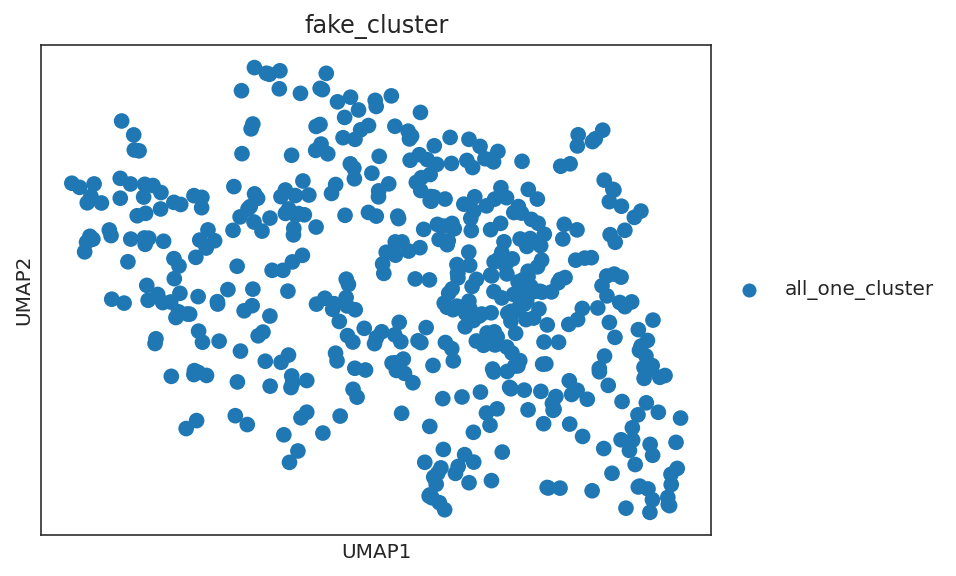

Working on results/pruning_v1/0.celloracle.oracle
Memoized results found.
Predicting ZNF780A
AATF AATF ALX3 ALX3 ALX4 ALX4 AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF3 ATF3 ATOH1 ATOH1 BANP BANP BARHL2 BARHL2 BATF3 
Prediction failed for BATF3 with error Gene BATF3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
BATF3 
Prediction failed for BATF3 with error Gene BATF3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
BCL6 BCL6 BHLHE40 BHLHE40 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CENPX CERS2 CERS2 CHD1 CREB1 CREB1 CREB3 CREB3 CTBP2 CTBP2 CTCFL CTCFL CUX1 CUX1 DLX3 DLX3 DLX4 DLX4 DLX6 DLX6 DMRT1 DMRT1 DMRTC2 
Prediction failed for DMRTC2 with error Gene DMRTC2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
DMRTC2 
Prediction failed for DMRTC2 with error Gene DMRTC2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
DVL2 DVL2 E2F1 

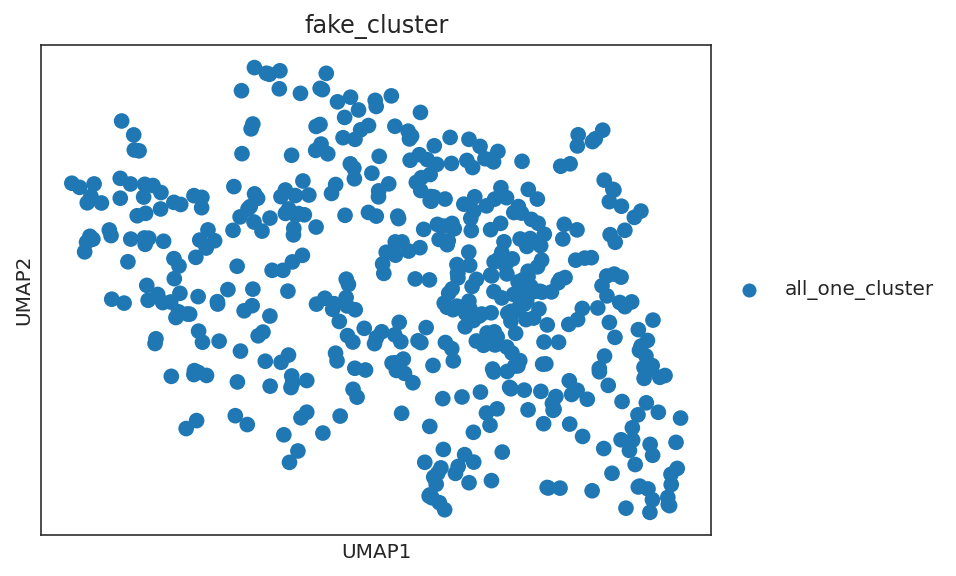

Working on results/pruning_v1/1.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 1767 genes
Predicting ZNF780A
AATF AATF ALX3 ALX3 ALX4 ALX4 AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF3 ATF3 ATOH1 ATOH1 BANP BANP BARHL2 BARHL2 BATF3 BATF3 BCL6 BCL6 BHLHE40 BHLHE40 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CENPX CERS2 CERS2 CHD1 CREB1 CREB1 CREB3 CREB3 CTBP2 CTBP2 CTCFL CTCFL CUX1 CUX1 DLX3 DLX3 DLX4 DLX4 DLX6 DLX6 DMRT1 DMRT1 DMRTC2 DMRTC2 DVL2 DVL2 E2F1 E2F1 E2F4 E2F4 E2F7 E2F7 EBF1 EBF1 EGR1 EGR1 EGR2 EGR2 EHF EHF ELF1 ELF1 ELF4 ELF5 ELF5 ELK1 ELK1 EN1 EN1 EOMES EOMES ERG ERG ESR1 ESR1 ESRRB ESRRB ESRRG ESRRG ESX1 ESX1 ETV5 ETV5 FEV FEV FLI1 FLI1 FOXC1 FOXC1 FOXD3 FOXD3 FOXD4L3 FOXD4L3 FOXE3 FOXE3 FOXJ1 FOXJ1 FOXM1 FOXM1 FOXO3 FOXO3 FOXP1 FOXP1 FOXP1 FOXP3 FOXP3 GABPA GABPA GADD45A GADD45A GATA2 GATA2 GATA3 GATA3 GATA6 GATA6 GBX2 GBX2 GLI1 GLI1 GLIS2 GLIS2 GRHL2 GRHL2 GSC GSC GTF2B GTF2B GTF2F1 GTF2F1 GTF3C2 GTF3C2 HDAC2 HDAC2 HDAC6 HDAC6 HES1 HES1 HESX1 HESX1 HEY1 HEY1 HMGB2 HMGB2 HMGXB4 HMGXB4 HNF1A HOPX HOP

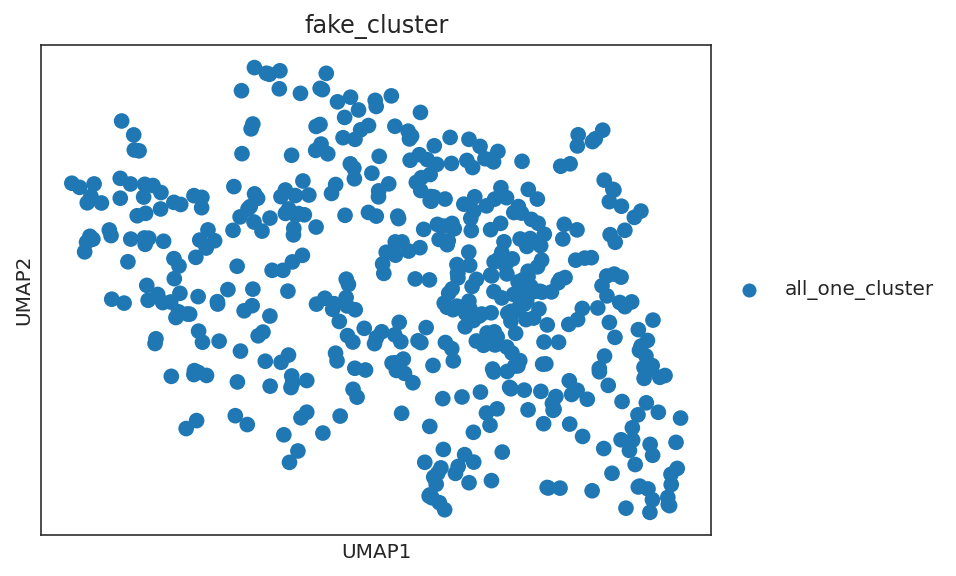

Working on results/pruning_v1/2.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2246 genes
Predicting ZNF780A
AATF AATF ALX3 ALX3 ALX4 ALX4 AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF3 ATF3 ATOH1 ATOH1 BANP BANP BARHL2 BARHL2 BATF3 BATF3 BCL6 BCL6 BHLHE40 BHLHE40 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CENPX CERS2 CERS2 CHD1 CREB1 CREB1 CREB3 CREB3 CTBP2 CTBP2 CTCFL CTCFL CUX1 CUX1 DLX3 DLX3 DLX4 DLX4 DLX6 DLX6 DMRT1 DMRT1 DMRTC2 DMRTC2 DVL2 DVL2 E2F1 E2F1 E2F4 E2F4 E2F7 E2F7 EBF1 EBF1 EGR1 EGR1 EGR2 EGR2 EHF EHF ELF1 ELF1 ELF4 ELF5 ELF5 ELK1 ELK1 EN1 EN1 EOMES EOMES ERG ERG ESR1 ESR1 ESRRB ESRRB ESRRG ESRRG ESX1 ESX1 ETV5 ETV5 FEV FEV FLI1 FLI1 FOXC1 FOXC1 FOXD3 FOXD3 FOXD4L3 FOXD4L3 FOXE3 FOXE3 FOXJ1 FOXJ1 FOXM1 FOXM1 FOXO3 FOXO3 FOXP1 FOXP1 FOXP1 FOXP3 FOXP3 GABPA GABPA GADD45A GADD45A GATA2 GATA2 GATA3 GATA3 GATA6 GATA6 GBX2 GBX2 GLI1 GLI1 GLIS2 GLIS2 GRHL2 GRHL2 GSC GSC GTF2B GTF2B GTF2F1 GTF2F1 GTF3C2 GTF3C2 HDAC2 HDAC2 HDAC6 HDAC6 HES1 HES1 HESX1 HESX1 HEY1 HEY1 HMGB2 HMGB2 HMGXB4 HMGXB4 HNF1A HOPX HOP

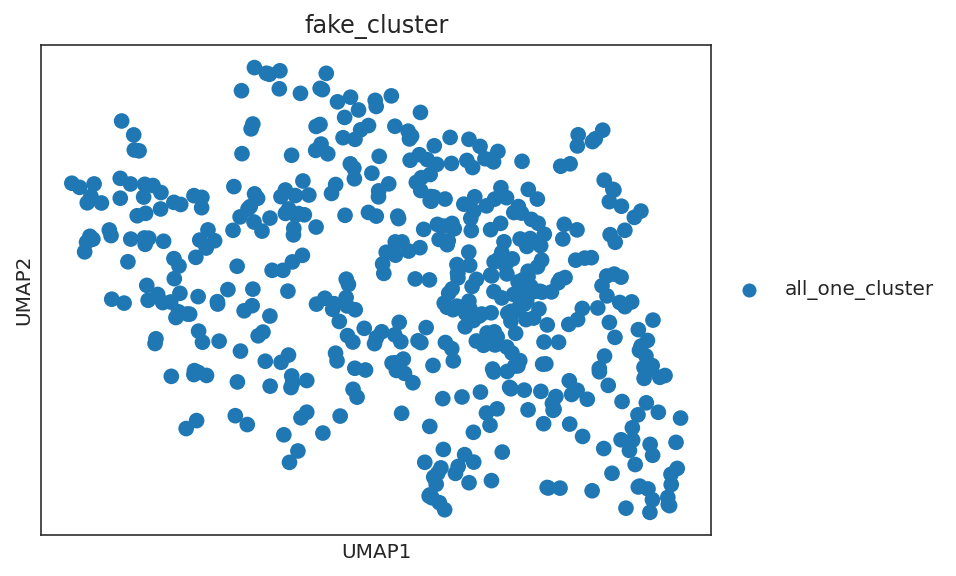

Working on results/pruning_v1/3.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2327 genes
Predicting ZNF780A
AATF AATF ALX3 ALX3 ALX4 ALX4 AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF3 ATF3 ATOH1 ATOH1 BANP BANP BARHL2 BARHL2 BATF3 BATF3 BCL6 BCL6 BHLHE40 BHLHE40 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CENPX CERS2 CERS2 CHD1 CREB1 CREB1 CREB3 CREB3 CTBP2 CTBP2 CTCFL CTCFL CUX1 CUX1 DLX3 DLX3 DLX4 DLX4 DLX6 DLX6 DMRT1 DMRT1 DMRTC2 DMRTC2 DVL2 DVL2 E2F1 E2F1 E2F4 E2F4 E2F7 E2F7 EBF1 EBF1 EGR1 EGR1 EGR2 EGR2 EHF EHF ELF1 ELF1 ELF4 ELF5 ELF5 ELK1 ELK1 EN1 EN1 EOMES EOMES ERG ERG ESR1 ESR1 ESRRB ESRRB ESRRG ESRRG ESX1 ESX1 ETV5 ETV5 FEV FEV FLI1 FLI1 FOXC1 FOXC1 FOXD3 FOXD3 FOXD4L3 FOXD4L3 FOXE3 FOXE3 FOXJ1 FOXJ1 FOXM1 FOXM1 FOXO3 FOXO3 FOXP1 FOXP1 FOXP1 FOXP3 FOXP3 GABPA GABPA GADD45A GADD45A GATA2 GATA2 GATA3 GATA3 GATA6 GATA6 GBX2 GBX2 GLI1 GLI1 GLIS2 GLIS2 GRHL2 GRHL2 GSC GSC GTF2B GTF2B GTF2F1 GTF2F1 GTF3C2 GTF3C2 HDAC2 HDAC2 HDAC6 HDAC6 HES1 HES1 HESX1 HESX1 HEY1 HEY1 HMGB2 HMGB2 HMGXB4 HMGXB4 HNF1A HOPX HOP

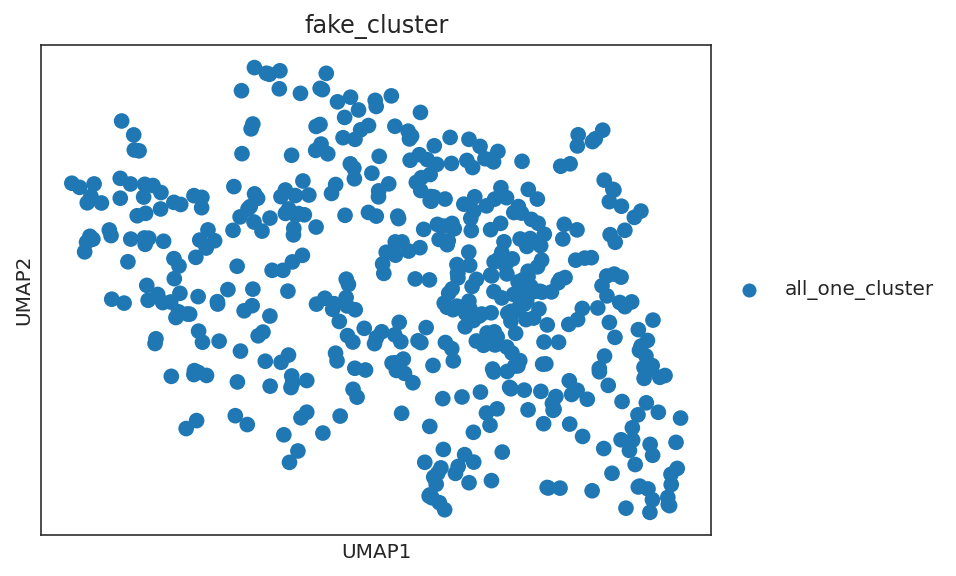

Working on results/pruning_v1/4.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2359 genes
Predicting ZNF780A
AATF AATF ALX3 ALX3 ALX4 ALX4 AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF3 ATF3 ATOH1 ATOH1 BANP BANP BARHL2 BARHL2 BATF3 BATF3 BCL6 BCL6 BHLHE40 BHLHE40 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CENPX CERS2 CERS2 CHD1 CREB1 CREB1 CREB3 CREB3 CTBP2 CTBP2 CTCFL CTCFL CUX1 CUX1 DLX3 DLX3 DLX4 DLX4 DLX6 DLX6 DMRT1 DMRT1 DMRTC2 DMRTC2 DVL2 DVL2 E2F1 E2F1 E2F4 E2F4 E2F7 E2F7 EBF1 EBF1 EGR1 EGR1 EGR2 EGR2 EHF EHF ELF1 ELF1 ELF4 ELF5 ELF5 ELK1 ELK1 EN1 EN1 EOMES EOMES ERG ERG ESR1 ESR1 ESRRB ESRRB ESRRG ESRRG ESX1 ESX1 ETV5 ETV5 FEV FEV FLI1 FLI1 FOXC1 FOXC1 FOXD3 FOXD3 FOXD4L3 FOXD4L3 FOXE3 FOXE3 FOXJ1 FOXJ1 FOXM1 FOXM1 FOXO3 FOXO3 FOXP1 FOXP1 FOXP1 FOXP3 FOXP3 GABPA GABPA GADD45A GADD45A GATA2 GATA2 GATA3 GATA3 GATA6 GATA6 GBX2 GBX2 GLI1 GLI1 GLIS2 GLIS2 GRHL2 GRHL2 GSC GSC GTF2B GTF2B GTF2F1 GTF2F1 GTF3C2 GTF3C2 HDAC2 HDAC2 HDAC6 HDAC6 HES1 HES1 HESX1 HESX1 HEY1 HEY1 HMGB2 HMGB2 HMGXB4 HMGXB4 HNF1A HOPX HOP

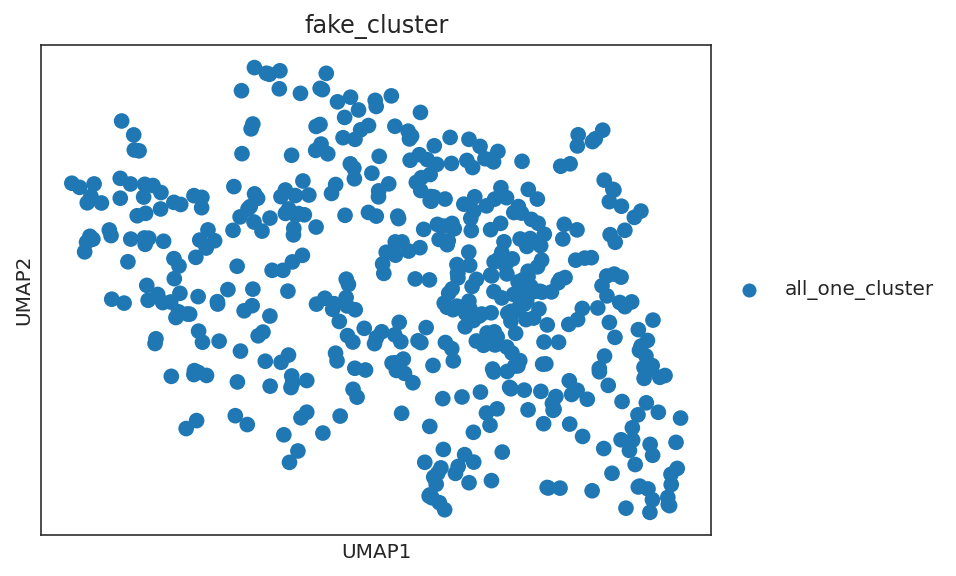

Working on results/pruning_v1/5.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2407 genes
Predicting ZNF780A
AATF AATF ALX3 ALX3 ALX4 ALX4 AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF3 ATF3 ATOH1 ATOH1 BANP BANP BARHL2 BARHL2 BATF3 BATF3 BCL6 BCL6 BHLHE40 BHLHE40 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CENPX CERS2 CERS2 CHD1 CREB1 CREB1 CREB3 CREB3 CTBP2 CTBP2 CTCFL CTCFL CUX1 CUX1 DLX3 DLX3 DLX4 DLX4 DLX6 DLX6 DMRT1 DMRT1 DMRTC2 DMRTC2 DVL2 DVL2 E2F1 E2F1 E2F4 E2F4 E2F7 E2F7 EBF1 EBF1 EGR1 EGR1 EGR2 EGR2 EHF EHF ELF1 ELF1 ELF4 ELF5 ELF5 ELK1 ELK1 EN1 EN1 EOMES EOMES ERG ERG ESR1 ESR1 ESRRB ESRRB ESRRG ESRRG ESX1 ESX1 ETV5 ETV5 FEV FEV FLI1 FLI1 FOXC1 FOXC1 FOXD3 FOXD3 FOXD4L3 FOXD4L3 FOXE3 FOXE3 FOXJ1 FOXJ1 FOXM1 FOXM1 FOXO3 FOXO3 FOXP1 FOXP1 FOXP1 FOXP3 FOXP3 GABPA GABPA GADD45A GADD45A GATA2 GATA2 GATA3 GATA3 GATA6 GATA6 GBX2 GBX2 GLI1 GLI1 GLIS2 GLIS2 GRHL2 GRHL2 GSC GSC GTF2B GTF2B GTF2F1 GTF2F1 GTF3C2 GTF3C2 HDAC2 HDAC2 HDAC6 HDAC6 HES1 HES1 HESX1 HESX1 HEY1 HEY1 HMGB2 HMGB2 HMGXB4 HMGXB4 HNF1A HOPX HOP

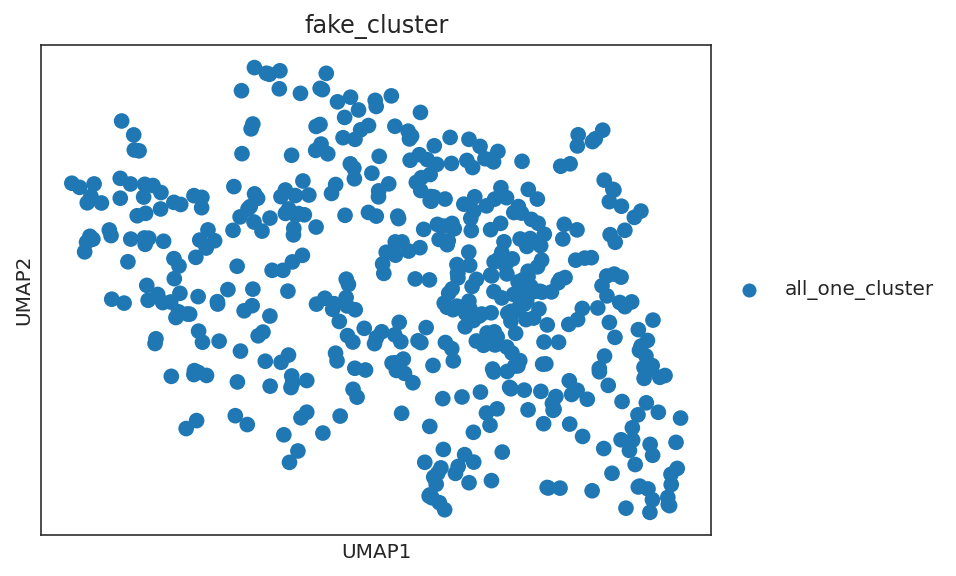

Working on results/pruning_v1/6.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2407 genes
Predicting ZNF780A
AATF AATF ALX3 ALX3 ALX4 ALX4 AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF3 ATF3 ATOH1 ATOH1 BANP BANP BARHL2 BARHL2 BATF3 BATF3 BCL6 BCL6 BHLHE40 BHLHE40 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CENPX CERS2 CERS2 CHD1 CREB1 CREB1 CREB3 CREB3 CTBP2 CTBP2 CTCFL CTCFL CUX1 CUX1 DLX3 DLX3 DLX4 DLX4 DLX6 DLX6 DMRT1 DMRT1 DMRTC2 DMRTC2 DVL2 DVL2 E2F1 E2F1 E2F4 E2F4 E2F7 E2F7 EBF1 EBF1 EGR1 EGR1 EGR2 EGR2 EHF EHF ELF1 ELF1 ELF4 ELF5 ELF5 ELK1 ELK1 EN1 EN1 EOMES EOMES ERG ERG ESR1 ESR1 ESRRB ESRRB ESRRG ESRRG ESX1 ESX1 ETV5 ETV5 FEV FEV FLI1 FLI1 FOXC1 FOXC1 FOXD3 FOXD3 FOXD4L3 FOXD4L3 FOXE3 FOXE3 FOXJ1 FOXJ1 FOXM1 FOXM1 FOXO3 FOXO3 FOXP1 FOXP1 FOXP1 FOXP3 FOXP3 GABPA GABPA GADD45A GADD45A GATA2 GATA2 GATA3 GATA3 GATA6 GATA6 GBX2 GBX2 GLI1 GLI1 GLIS2 GLIS2 GRHL2 GRHL2 GSC GSC GTF2B GTF2B GTF2F1 GTF2F1 GTF3C2 GTF3C2 HDAC2 HDAC2 HDAC6 HDAC6 HES1 HES1 HESX1 HESX1 HEY1 HEY1 HMGB2 HMGB2 HMGXB4 HMGXB4 HNF1A HOPX HOP

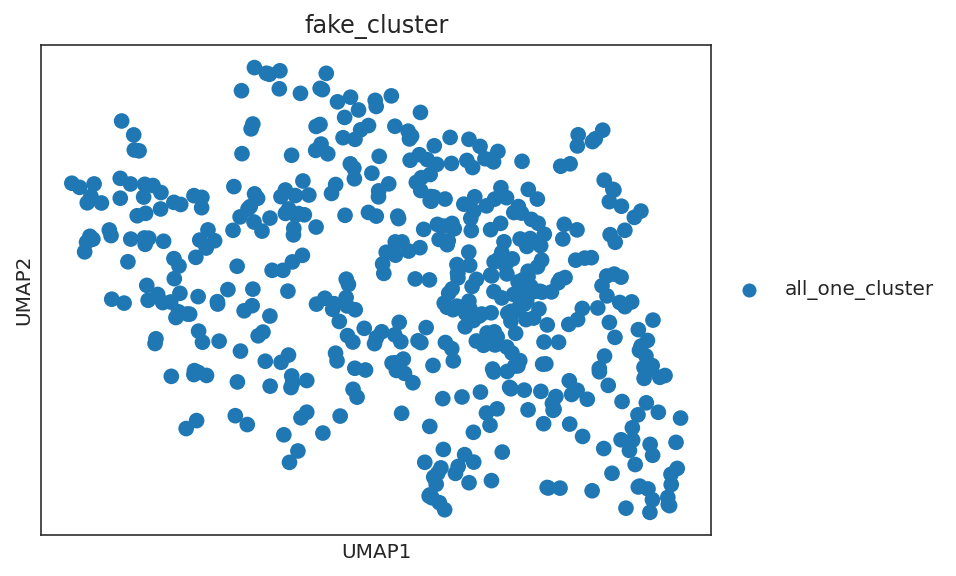

Working on results/pruning_v1/7.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2407 genes
Predicting ZNF780A
AATF AATF ALX3 ALX3 ALX4 ALX4 AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF3 ATF3 ATOH1 ATOH1 BANP BANP BARHL2 BARHL2 BATF3 BATF3 BCL6 BCL6 BHLHE40 BHLHE40 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CENPX CERS2 CERS2 CHD1 CREB1 CREB1 CREB3 CREB3 CTBP2 CTBP2 CTCFL CTCFL CUX1 CUX1 DLX3 DLX3 DLX4 DLX4 DLX6 DLX6 DMRT1 DMRT1 DMRTC2 DMRTC2 DVL2 DVL2 E2F1 E2F1 E2F4 E2F4 E2F7 E2F7 EBF1 EBF1 EGR1 EGR1 EGR2 EGR2 EHF EHF ELF1 ELF1 ELF4 ELF5 ELF5 ELK1 ELK1 EN1 EN1 EOMES EOMES ERG ERG ESR1 ESR1 ESRRB ESRRB ESRRG ESRRG ESX1 ESX1 ETV5 ETV5 FEV FEV FLI1 FLI1 FOXC1 FOXC1 FOXD3 FOXD3 FOXD4L3 FOXD4L3 FOXE3 FOXE3 FOXJ1 FOXJ1 FOXM1 FOXM1 FOXO3 FOXO3 FOXP1 FOXP1 FOXP1 FOXP3 FOXP3 GABPA GABPA GADD45A GADD45A GATA2 GATA2 GATA3 GATA3 GATA6 GATA6 GBX2 GBX2 GLI1 GLI1 GLIS2 GLIS2 GRHL2 GRHL2 GSC GSC GTF2B GTF2B GTF2F1 GTF2F1 GTF3C2 GTF3C2 HDAC2 HDAC2 HDAC6 HDAC6 HES1 HES1 HESX1 HESX1 HEY1 HEY1 HMGB2 HMGB2 HMGXB4 HMGXB4 HNF1A HOPX HOP

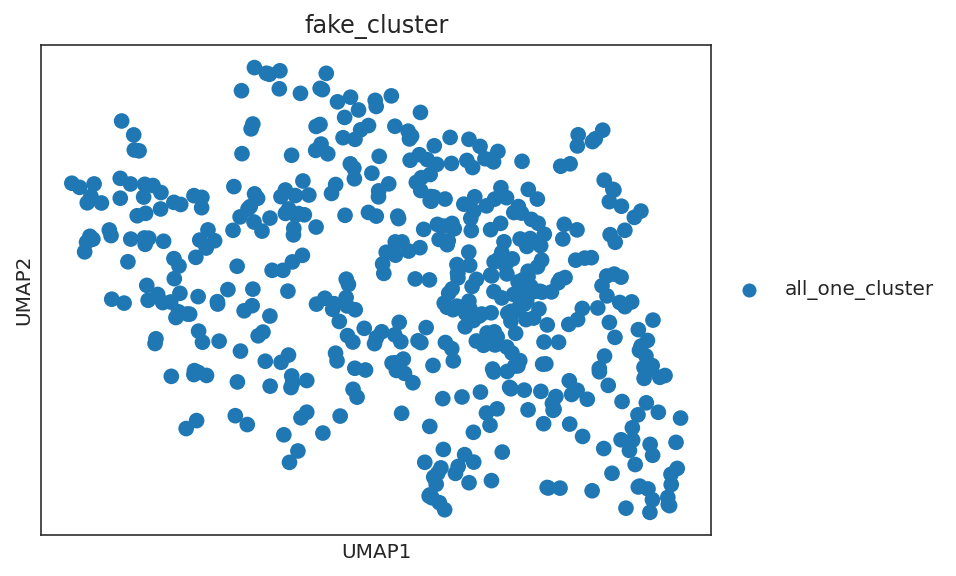

Working on results/pruning_v1/8.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2407 genes
Predicting ZNF780A
AATF AATF ALX3 ALX3 ALX4 ALX4 AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF3 ATF3 ATOH1 ATOH1 BANP BANP BARHL2 BARHL2 BATF3 BATF3 BCL6 BCL6 BHLHE40 BHLHE40 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CENPX CERS2 CERS2 CHD1 CREB1 CREB1 CREB3 CREB3 CTBP2 CTBP2 CTCFL CTCFL CUX1 CUX1 DLX3 DLX3 DLX4 DLX4 DLX6 DLX6 DMRT1 DMRT1 DMRTC2 DMRTC2 DVL2 DVL2 E2F1 E2F1 E2F4 E2F4 E2F7 E2F7 EBF1 EBF1 EGR1 EGR1 EGR2 EGR2 EHF EHF ELF1 ELF1 ELF4 ELF5 ELF5 ELK1 ELK1 EN1 EN1 EOMES EOMES ERG ERG ESR1 ESR1 ESRRB ESRRB ESRRG ESRRG ESX1 ESX1 ETV5 ETV5 FEV FEV FLI1 FLI1 FOXC1 FOXC1 FOXD3 FOXD3 FOXD4L3 FOXD4L3 FOXE3 FOXE3 FOXJ1 FOXJ1 FOXM1 FOXM1 FOXO3 FOXO3 FOXP1 FOXP1 FOXP1 FOXP3 FOXP3 GABPA GABPA GADD45A GADD45A GATA2 GATA2 GATA3 GATA3 GATA6 GATA6 GBX2 GBX2 GLI1 GLI1 GLIS2 GLIS2 GRHL2 GRHL2 GSC GSC GTF2B GTF2B GTF2F1 GTF2F1 GTF3C2 GTF3C2 HDAC2 HDAC2 HDAC6 HDAC6 HES1 HES1 HESX1 HESX1 HEY1 HEY1 HMGB2 HMGB2 HMGXB4 HMGXB4 HNF1A HOPX HOP

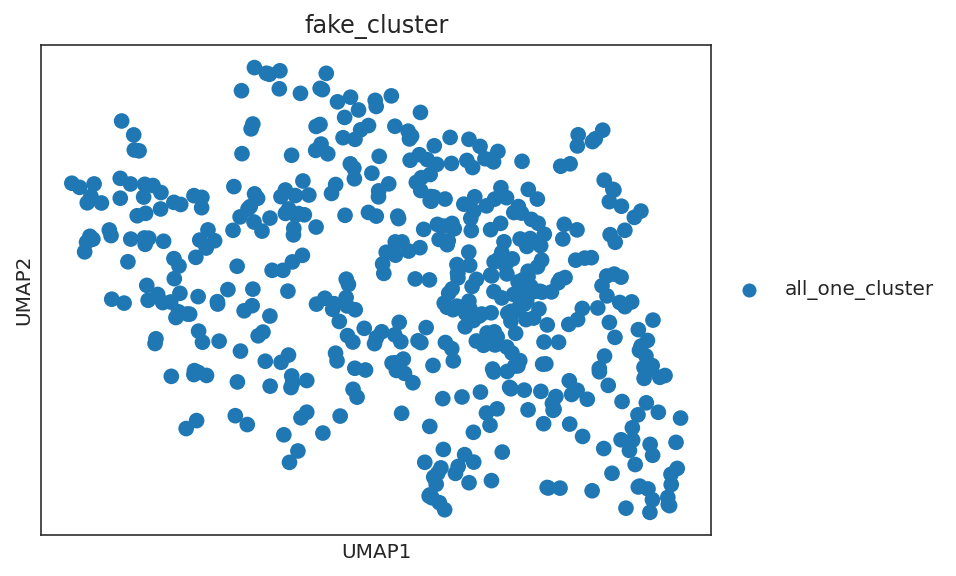

Working on results/pruning_v1/9.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2407 genes
Predicting ZNF780A
AATF AATF ALX3 ALX3 ALX4 ALX4 AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF3 ATF3 ATOH1 ATOH1 BANP BANP BARHL2 BARHL2 BATF3 BATF3 BCL6 BCL6 BHLHE40 BHLHE40 BLZF1 BLZF1 BMP4 BMP4 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CENPX CERS2 CERS2 CHD1 CREB1 CREB1 CREB3 CREB3 CTBP2 CTBP2 CTCFL CTCFL CUX1 CUX1 DLX3 DLX3 DLX4 DLX4 DLX6 DLX6 DMRT1 DMRT1 DMRTC2 DMRTC2 DVL2 DVL2 E2F1 E2F1 E2F4 E2F4 E2F7 E2F7 EBF1 EBF1 EGR1 EGR1 EGR2 EGR2 EHF EHF ELF1 ELF1 ELF4 ELF5 ELF5 ELK1 ELK1 EN1 EN1 EOMES EOMES ERG ERG ESR1 ESR1 ESRRB ESRRB ESRRG ESRRG ESX1 ESX1 ETV5 ETV5 FEV FEV FLI1 FLI1 FOXC1 FOXC1 FOXD3 FOXD3 FOXD4L3 FOXD4L3 FOXE3 FOXE3 FOXJ1 FOXJ1 FOXM1 FOXM1 FOXO3 FOXO3 FOXP1 FOXP1 FOXP1 FOXP3 FOXP3 GABPA GABPA GADD45A GADD45A GATA2 GATA2 GATA3 GATA3 GATA6 GATA6 GBX2 GBX2 GLI1 GLI1 GLIS2 GLIS2 GRHL2 GRHL2 GSC GSC GTF2B GTF2B GTF2F1 GTF2F1 GTF3C2 GTF3C2 HDAC2 HDAC2 HDAC6 HDAC6 HES1 HES1 HESX1 HESX1 HEY1 HEY1 HMGB2 HMGB2 HMGXB4 HMGXB4 HNF1A HOPX HOP

In [9]:
predictions = {
    i: evaluator.trainCausalModelAndPredict(expression=ko_lab_esc_data_train,
                                  baseNetwork=networks[experiments.loc[i,'network']],
                                  memoizationName="results/" + EXPERIMENT_NAME + "/" + str(i) + ".celloracle.oracle", 
                                  perturbations=perturbationsToPredict,
                                  clusterColumnName = "fake_cluster",
                                  pruningParameters = {"p":experiments.loc[i,'p'], 
                                                       "threshold_number":experiments.loc[i,'threshold_number']}) 
    for i in experiments.index
}


In [13]:
predictions[0]

{'AATF': ArrayView([0.18163939, 0.74551463, 0.4831264 , ..., 1.40417194,
            0.46830875, 0.57934713]),
 'ALX3': ArrayView([0.18163939, 0.74551463, 0.4831264 , ..., 1.40417194,
            0.46830875, 0.57934713]),
 'ALX4': ArrayView([0.18163939, 0.74551463, 0.4831264 , ..., 1.40417194,
            0.46830875, 0.57934713]),
 'AR': ArrayView([0.18163939, 0.74551463, 0.4831264 , ..., 1.40417194,
            0.46830875, 0.57934713]),
 'ARNT2': ArrayView([0.18163939, 0.74551463, 0.4831264 , ..., 1.40417194,
            0.46830875, 0.57934713]),
 'ASCL1': ArrayView([0.18163939, 0.74551463, 0.4831264 , ..., 1.40417194,
            0.46830875, 0.57934713]),
 'ATF3': ArrayView([0.18163939, 0.74551463, 0.4831264 , ..., 1.40417194,
            0.46830875, 0.57934713]),
 'ATOH1': ArrayView([0.18163939, 0.74551463, 0.4831264 , ..., 1.40417194,
            0.46830875, 0.57934713]),
 'BANP': ArrayView([0.18163939, 0.74551463, 0.4831264 , ..., 1.40417194,
            0.46830875, 0.57934713]),


### Evaluation

We compute the correlation of the predictions with held-out perturbations.

In [91]:
controlIndex = ko_lab_esc_data_train.obs["perturbation"]=="Control"
evaluationResults = {}
for i in predictions:
    evaluationResults[i] = \
        evaluator.evaluateCausalModel(ko_lab_esc_data_heldout, 
                                      predictions[i],   
                                      baseline = ko_lab_esc_data_train[controlIndex,:].X.mean(axis=0),     
                                      doPlots=False, 
                                      classifier=cellFateClassifier
                                     )[0]
    evaluationResults[i]["index"] = i
evaluationResults = pd.concat(evaluationResults)
evaluationResults = evaluationResults.merge(experiments, how = "left")
evaluationResults = pd.DataFrame(evaluationResults.to_dict())
evaluationResults.head()

,spearman,spearmanp,cell_fate_correct,perturbation,index,threshold_number,network,p,pruning
0,0.185891,1.143875e-21,0.0,AATF,0,20000,dense,1,none
1,0.167774,6.885811e-18,0.0,ALX3,0,20000,dense,1,none
2,0.138010,1.530265e-12,0.0,ALX4,0,20000,dense,1,none
3,0.179978,2.168925e-20,0.0,AR,0,20000,dense,1,none
4,0.133775,7.246177e-12,0.0,ARNT2,0,20000,dense,1,none


In [92]:
noPredictionMade = evaluationResults.iloc[[x==0 for x in evaluationResults["spearman"]],:]['perturbation']
noPredictionMade = set(noPredictionMade)
noPredictionMade
evaluationResults["somePredictionRefused"] = evaluationResults["perturbation"].isin(noPredictionMade) 
evaluationResults.to_csv("results/"+ EXPERIMENT_NAME +"/evaluationResults.csv")
evaluationResults.head()

,spearman,spearmanp,cell_fate_correct,perturbation,index,threshold_number,network,p,pruning,somePredictionRefused
0,0.185891,1.143875e-21,0.0,AATF,0,20000,dense,1,none,False
1,0.167774,6.885811e-18,0.0,ALX3,0,20000,dense,1,none,False
2,0.138010,1.530265e-12,0.0,ALX4,0,20000,dense,1,none,False
3,0.179978,2.168925e-20,0.0,AR,0,20000,dense,1,none,False
4,0.133775,7.246177e-12,0.0,ARNT2,0,20000,dense,1,none,False


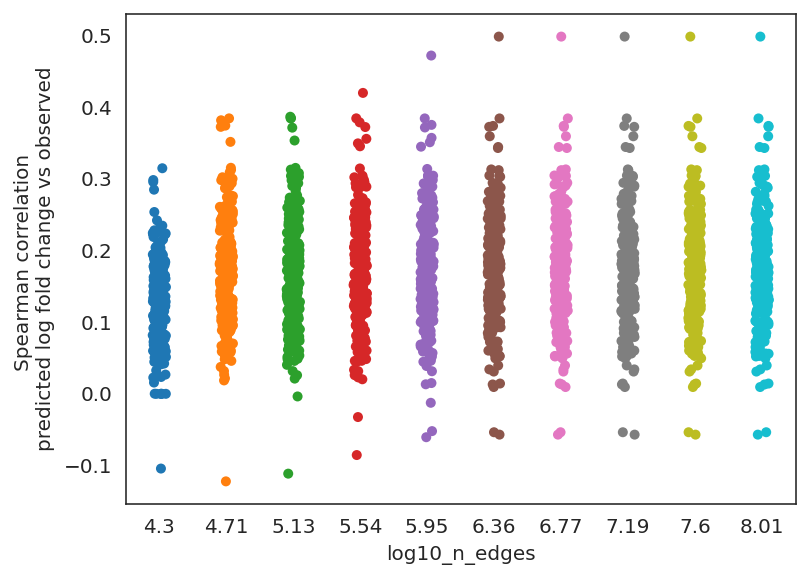

In [93]:
evaluationResults["log10_n_edges"] = round(np.log10(evaluationResults["threshold_number"]), 2)
stripchartMainFig = sns.stripplot(y = "spearman", 
                                             x="log10_n_edges", 
                                             data = evaluationResults)
stripchartMainFig.set(ylabel="Spearman correlation \npredicted log fold change vs observed")
stripchartMainFig.figure.savefig(f'results/{EXPERIMENT_NAME}/stripchart.pdf')

plt.show()

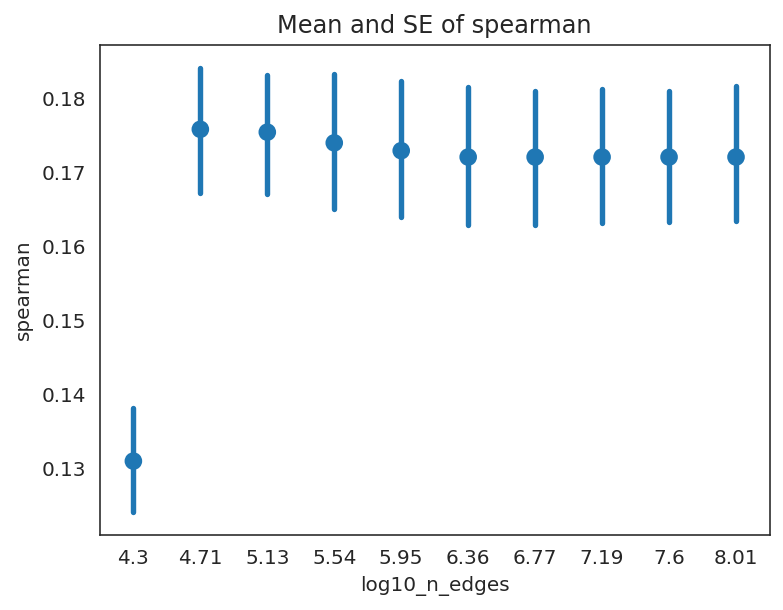

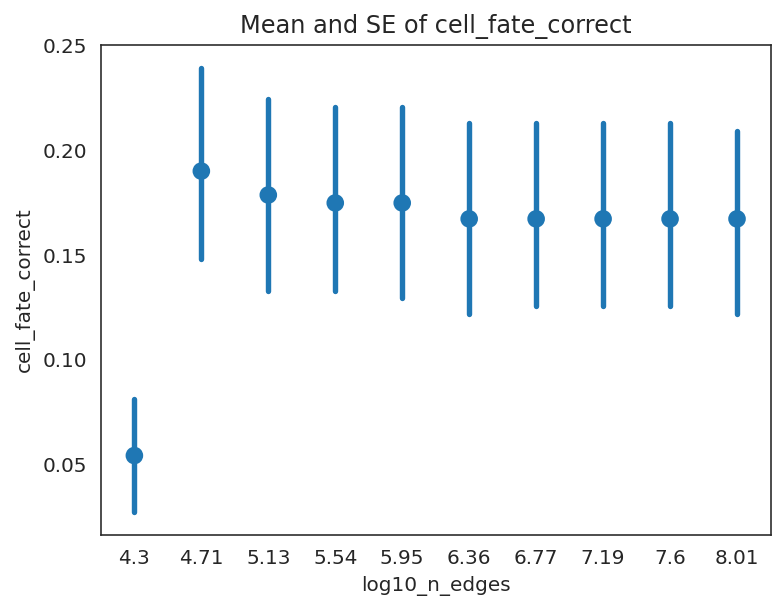

<Figure size 432x324 with 0 Axes>

In [94]:
evaluationResults["log10_n_edges"] = round(np.log10(evaluationResults["threshold_number"]), 2)
for readout in "spearman", "cell_fate_correct":
    meanSEPlot = sns.pointplot("log10_n_edges", y=readout, data=evaluationResults, dodge=True, join=False)
    meanSEPlot.set(title="Mean and SE of " + readout)
    meanSEPlot.figure.savefig(f'results/{EXPERIMENT_NAME}/MeanSEPlot{readout}.pdf')
    plt.show()
    plt.figure()

In [95]:
evaluationResults.loc[evaluationResults["perturbation"]=="MYOD1",:]
evaluationResults.loc[evaluationResults["perturbation"]=="MXI1",:]

,spearman,spearmanp,cell_fate_correct,perturbation,index,threshold_number,network,p,pruning,somePredictionRefused,log10_n_edges
111,-0.104255,9.764976e-08,0.0,MXI1,0,20000,dense,1,none,False,4.30
374,-0.122119,4.081872e-10,0.0,MXI1,1,51657,dense,1,none,False,4.71
637,-0.111366,1.220356e-08,0.0,MXI1,2,133422,dense,1,none,False,5.13
900,-0.085400,1.283035e-05,0.0,MXI1,3,344612,dense,1,none,False,5.54
1163,-0.060533,2.003505e-03,0.0,MXI1,4,890083,dense,1,none,False,5.95
1426,-0.053586,6.246310e-03,0.0,MXI1,5,2298958,dense,1,none,False,6.36
1689,-0.053586,6.246310e-03,0.0,MXI1,6,5937879,dense,1,none,False,6.77
1952,-0.053586,6.246310e-03,0.0,MXI1,7,15336688,dense,1,none,False,7.19
2215,-0.053586,6.246310e-03,0.0,MXI1,8,39612462,dense,1,none,False,7.60
2478,-0.053586,6.246310e-03,0.0,MXI1,9,102313294,dense,1,none,False,8.01
